</font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

In [1]:
filename_version='3dot10'

In [2]:
import sys
source_directory = "/Users/pauljacob/Library/Python/3.8/lib/python/site-packages"

sys.path.append(source_directory)

In [3]:
#file structure
!pip3 install cookiecutter

#general
!pip3 install --upgrade pip
!pip3 install ipython-autotime --quiet


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
%load_ext autotime

time: 246 µs (started: 2023-01-18 15:01:59 -08:00)


## Import Libraries

In [5]:
#get libraries
import pandas as pd
import os
import numpy as np
import itertools


#get visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.patches as mpatches



#ML preprocessing
from sklearn.preprocessing import StandardScaler

#get ML functions
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from sklearn import __version__ as sklearn_version
import datetime


#get ML metric functions
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, log_loss, auc, brier_score_loss
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report, brier_score_loss
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import log_loss

#get icr module and associated common functions
import in_vehicle_coupon_recommendation as icr
from in_vehicle_coupon_recommendation import p, rcp, rpp, rcr, sr, pl, pdc, save_and_return_data_frame, initialize_custom_notebook_settings

#sound alert
from IPython.display import Audio

time: 1.61 s (started: 2023-01-18 15:01:59 -08:00)


In [6]:
#initialize notebook
initialize_custom_notebook_settings()

%load_ext autoreload
%autoreload 1
%aimport in_vehicle_coupon_recommendation 


time: 25.6 ms (started: 2023-01-18 15:02:01 -08:00)


## Get In-Vehicle Coupon Recommendation Dataset

In [7]:
df = pd.read_csv(os.path.join('..', 'data', 'raw', 'in-vehicle-coupon-recommendation.csv'))
df = df.sample(frac=1, random_state=200)
#p(df)

time: 39.3 ms (started: 2023-01-18 15:02:01 -08:00)


<font size="5"><a id='[Data_Wrangling]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Data_Wrangling]'>**Data Wrangling**</a> </font>

In [8]:
#rename 'passanger' and 'coupon' column
df = df.rename(columns={'passanger':'passenger', 'coupon':'coupon_venue_type'})


#decode string 'age' values to (explicit) string age ranges
column_name_age_value_list = list(df.loc[:, 'age'].unique())
column_name_age_value_list_cleaned_up = ['21-25', '46-49', '26-30', '31-35', '41-45', '50+', '36-40', '<21']
column_name_age_value_dict = dict(zip(column_name_age_value_list, column_name_age_value_list_cleaned_up))
df.loc[:, 'age'] = df.loc[:, 'age'].replace(column_name_age_value_dict)

del column_name_age_value_dict, column_name_age_value_list, column_name_age_value_list_cleaned_up


#drop column 'toCoupon_GEQ5min' because all 1's
column_name_list_not_toCoupon_GEQ5min = [column_name for column_name in df.columns if column_name != 'toCoupon_GEQ5min']
df = df.loc[:, column_name_list_not_toCoupon_GEQ5min]

del column_name_list_not_toCoupon_GEQ5min


#rename values in columns 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', and 'Restaurant20To50' to math language...
#get column name list for column values uniques that are the same as column name 'CarryAway' value uniques
column_name_list_same_unique_values = []
for column_name in df.columns:    
    value = icr.column_name_value_sets_equal(df, column_name1='CarryAway', column_name2=column_name)
    if value == 1:
        column_name_list_same_unique_values = column_name_list_same_unique_values + [column_name]
#rename values in columns 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', and 'Restaurant20To50' to math language
column_name_Bar_value_list = list(df.loc[:, 'Bar'].unique())
column_name_Bar_value_list_cleaned_up = ['never', '<1', '1-3', '>8', np.nan, '4-8']
column_name_Bar_value_dict = dict(zip(column_name_Bar_value_list, column_name_Bar_value_list_cleaned_up))
df.loc[:, column_name_list_same_unique_values] = df.loc[:, column_name_list_same_unique_values].replace(column_name_Bar_value_dict)

del column_name_Bar_value_dict, column_name_Bar_value_list, column_name_Bar_value_list_cleaned_up, column_name_list_same_unique_values


#clean up columns 'direction_same' and 'direction_opp' to 'direction_same_or_opposite'
#drop column 'direction_same'
column_name_list_not_direction_same = [column_name for column_name in df.columns if column_name != 'direction_same']
df = df.loc[:, column_name_list_not_direction_same]

del column_name_list_not_direction_same

#rename 'direction_opp' to 'direction_same_or_opposite'
df = df.rename(columns={'direction_opp':'direction_same_or_opposite'})


#solution1: fill in missing values with 'no response' or 'unknown'
column_name_list = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'car']
df.loc[:, column_name_list] = df.loc[:, column_name_list].fillna('no response')


#fix income values
income_list = df.loc[:, 'income'].drop_duplicates().to_list()
income_list_fixed = ['\$12500 - \$24999', '\$87500 - \$99999', '\$37500 - \$49999', '\$50000 - \$62499', '\$75000 - \$87499', '\$25000 - \$37499', '\$100000 or More', 'Less than \$12500', '\$62500 - \$74999']
income_dictionary = dict(zip(income_list, income_list_fixed))
df.loc[:, 'income'] = df.loc[:, 'income'].replace(income_dictionary)
p(df)



(12684, 24)


,destination,passenger,weather,temperature,time,coupon_venue_type,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,Y
11199,Home,Alone,Sunny,80,6PM,Carry out & Take away,2h,Male,21-25,Single,0,Bachelors degree,Student,\$12500 - \$24999,no response,never,no response,no response,no response,never,1,0,0,1
1474,Work,Alone,Sunny,55,7AM,Bar,1d,Male,46-49,Married partner,1,Graduate degree (Masters or Doctorate),Management,\$87500 - \$99999,no response,never,<1,<1,never,<1,1,1,1,0
10836,Home,Alone,Sunny,30,6PM,Carry out & Take away,1d,Male,26-30,Single,0,Some college - no degree,Sales & Related,\$37500 - \$49999,no response,<1,no response,>8,<1,never,0,0,1,1
4567,No Urgent Place,Alone,Sunny,80,10AM,Bar,1d,Female,21-25,Unmarried partner,0,Graduate degree (Masters or Doctorate),Education&Training&Library,\$37500 - \$49999,no response,1-3,<1,<1,<1,never,0,0,1,0
5658,No Urgent Place,Alone,Sunny,80,2PM,Restaurant(<20),2h,Female,31-35,Single,1,Bachelors degree,Production Occupations,\$37500 - \$49999,no response,never,never,>8,4-8,never,1,0,1,1
11343,Work,Alone,Sunny,80,7AM,Restaurant(20-50),2h,Female,36-40,Single,1,Bachelors degree,Food Preparation & Serving Related,\$12500 - \$24999,no response,1-3,<1,>8,never,never,0,0,0,0
9036,Home,Alone,Snowy,30,10PM,Restaurant(<20),2h,Male,26-30,Single,0,Some college - no degree,Student,\$12500 - \$24999,no response,<1,never,>8,never,1-3,1,1,1,0
11050,Home,Alone,Sunny,80,6PM,Restaurant(20-50),1d,Male,46-49,Single,0,Some college - no degree,Sales & Related,Less than \$12500,no response,<1,<1,>8,>8,>8,0,0,0,0
784,Work,Alone,Sunny,80,7AM,Carry out & Take away,2h,Female,21-25,Single,0,Graduate degree (Masters or Doctorate),Legal,\$25000 - \$37499,no response,<1,<1,<1,no response,<1,0,0,0,1
1818,No Urgent Place,Kid(s),Sunny,80,10AM,Bar,1d,Female,36-40,Married partner,1,Bachelors degree,Retired,\$50000 - \$62499,no response,1-3,never,>8,<1,never,1,0,1,0


time: 90.1 ms (started: 2023-01-18 15:02:01 -08:00)


### Store df_pre_feature_engineering from df

In [9]:
# df_pre_feature_engineering = df.copy()
# p(df_pre_feature_engineering)

time: 539 µs (started: 2023-01-18 15:02:01 -08:00)


In [10]:
column_name_list_scenario = ['destination', 'passenger', 'weather', 'temperature', 'time', 'coupon_venue_type', 'expiration', 
                             'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same_or_opposite']
pl(column_name_list_scenario)


10


['destination',
 'passenger',
 'weather',
 'temperature',
 'time',
 'coupon_venue_type',
 'expiration',
 'toCoupon_GEQ15min',
 'toCoupon_GEQ25min',
 'direction_same_or_opposite']

time: 2.52 ms (started: 2023-01-18 15:02:01 -08:00)


In [11]:
df.loc[:, column_name_list_scenario].drop_duplicates().shape

(201, 10)

time: 9.07 ms (started: 2023-01-18 15:02:01 -08:00)


In [12]:
df.loc[:, column_name_list_scenario].drop_duplicates() #there are plenty of combinations of sceanrios, what are the scenario counts??

#are some scenarios not represented and why???

,destination,passenger,weather,temperature,time,coupon_venue_type,expiration,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite
11199,Home,Alone,Sunny,80,6PM,Carry out & Take away,2h,1,0,0
1474,Work,Alone,Sunny,55,7AM,Bar,1d,1,1,1
10836,Home,Alone,Sunny,30,6PM,Carry out & Take away,1d,0,0,1
4567,No Urgent Place,Alone,Sunny,80,10AM,Bar,1d,0,0,1
5658,No Urgent Place,Alone,Sunny,80,2PM,Restaurant(<20),2h,1,0,1
431,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,0,0,1
11668,No Urgent Place,Partner,Rainy,55,6PM,Bar,2h,1,0,1
473,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,0,0,1
4732,Home,Alone,Sunny,80,10PM,Restaurant(<20),2h,0,0,0
2323,No Urgent Place,Friend(s),Sunny,80,6PM,Restaurant(<20),2h,1,0,1


time: 32.8 ms (started: 2023-01-18 15:02:01 -08:00)


In [13]:
df.loc[:, column_name_list_scenario].value_counts() #yes, the most represented scenario is heading to Work, alone, sunny weather, 55 degrees, 7am, bar, 
#1 day til expiration, >25 minute away in the opposite drive direction of destination


destination      passenger  weather  temperature  time  coupon_venue_type      expiration  toCoupon_GEQ15min  toCoupon_GEQ25min  direction_same_or_opposite
Work             Alone      Sunny    55           7AM   Bar                    1d          1                  1                  1                             194
No Urgent Place  Friend(s)  Sunny    55           2PM   Carry out & Take away  1d          1                  0                  1                             181
                                     80           2PM   Coffee House           2h          1                  0                  1                             181
Work             Alone      Sunny    80           7AM   Carry out & Take away  2h          0                  0                  0                             181
No Urgent Place  Alone      Sunny    55           2PM   Restaurant(<20)        1d          0                  0                  1                             181
                 Friend(s)  S

time: 15.5 ms (started: 2023-01-18 15:02:01 -08:00)


In [14]:
#how many permutations is there?

#expiration is 2
#temperature is 3
#time is 5

#201


time: 641 µs (started: 2023-01-18 15:02:01 -08:00)


In [15]:
df.value_counts('expiration') #imbalance in the expiration date??? why???? how does this influence our analysis????

expiration
1d    7091
2h    5593
dtype: int64

time: 3.62 ms (started: 2023-01-18 15:02:01 -08:00)


In [16]:
7091 / (7091 + 5593)

0.5590507726269316

time: 1.75 ms (started: 2023-01-18 15:02:01 -08:00)


In [17]:
df.loc[:, column_name_list_scenario].drop_duplicates().value_counts('expiration')

expiration
1d    118
2h     83
dtype: int64

time: 9.6 ms (started: 2023-01-18 15:02:01 -08:00)


In [18]:
101 / (101 + 73)

0.5804597701149425

time: 1.97 ms (started: 2023-01-18 15:02:01 -08:00)


<font size="5"><a id='[Feature_Engineering]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Feature_Engineering]'>**Feature Engineering**</a> </font>

## Get Category Representative Numeric Encoding for Features: expiration, time, age, income

In [19]:
#category representative numeric encoding: expiration, time, age, income

expiration_category_representative_numeric_encoding={'expiration':{'2h':2, '1d':24}}
time_category_representative_numeric_encoding={'time':{'7AM':7,'10AM':10, '2PM':14, '6PM':18, '10PM':22}}
age_category_representative_numeric_encoding={'age':{'<21':18, '21-25':23, '26-30':28, '31-35':33, '36-40':38, '41-45':43, '46-49':48, '50+':56}}
income_category_representative_numeric_encoding={'income':{'Less than \$12500':6250, '\$12500 - \$24999':18749.5, '\$25000 - \$37499':31249.5, '\$37500 - \$49999':43749.5, '\$50000 - \$62499':56249.5, '\$62500 - \$74999':68749.5, '\$75000 - \$87499':81249.5, '\$87500 - \$99999':93749.5,'\$100000 or More':150000}}

#combine category representative numeric encoding dictionaries
category_representative_numeric_encoding_dictionary = expiration_category_representative_numeric_encoding|time_category_representative_numeric_encoding|age_category_representative_numeric_encoding|income_category_representative_numeric_encoding

del expiration_category_representative_numeric_encoding, time_category_representative_numeric_encoding, age_category_representative_numeric_encoding, income_category_representative_numeric_encoding

category_representative_numeric_encoding_key_list = list(category_representative_numeric_encoding_dictionary.keys())

df_category_representative_numeric_encoding = df.loc[:, category_representative_numeric_encoding_key_list].replace(category_representative_numeric_encoding_dictionary)

del category_representative_numeric_encoding_dictionary, 

#rename columns
category_representative_numeric_encoding_substring='_category_representative_numeric_encoding'

column_name_list_category_representative_numeric_encoding = [str(column_name) + category_representative_numeric_encoding_substring for column_name in category_representative_numeric_encoding_key_list]

column_name_dictionary_category_representative_numeric_encoding = dict(zip(category_representative_numeric_encoding_key_list, column_name_list_category_representative_numeric_encoding))

df_category_representative_numeric_encoding = df_category_representative_numeric_encoding.rename(columns=column_name_dictionary_category_representative_numeric_encoding)

del column_name_dictionary_category_representative_numeric_encoding, column_name_list_category_representative_numeric_encoding, category_representative_numeric_encoding_key_list, category_representative_numeric_encoding_substring

#p(df_category_representative_numeric_encoding)

time: 25.1 ms (started: 2023-01-18 15:02:01 -08:00)


## Get Binary Encoding for Features: gender, expiration

In [20]:
#binary encoding: gender, expiration
gender_binary_encoding={'gender':{'Female':0, 'Male':1}}
expiration_binary_encoding={'expiration':{'2h':0, '1d':1}}

binary_encoding_dictionary = gender_binary_encoding|expiration_binary_encoding

del gender_binary_encoding, expiration_binary_encoding

binary_encoding_key_list = list(binary_encoding_dictionary.keys())

df_binary_encoding = df.loc[:, binary_encoding_key_list].replace(binary_encoding_dictionary)

del binary_encoding_dictionary


#rename columns
binary_encoding_substring = '_binary_encoding'
column_name_list_binary_encoding = [str(column_name) + binary_encoding_substring for column_name in binary_encoding_key_list]
column_name_dictionary_binary_encoding = dict(zip(binary_encoding_key_list, column_name_list_binary_encoding))
df_binary_encoding = df_binary_encoding.rename(columns=column_name_dictionary_binary_encoding)

del column_name_dictionary_binary_encoding, column_name_list_binary_encoding, binary_encoding_key_list, binary_encoding_substring

#p(df_binary_encoding)

time: 12 ms (started: 2023-01-18 15:02:01 -08:00)


## Get Ordinal Integer Encoding for Features: coupon_venue_type, education, income, age, time, temperature

In [21]:
#ordinal integer encoding: coupon_venue_type, education, income, age, time, temperature

#category ordinal features to ordinal integer encoding
coupon_venue_type_ordinal_integer_encoding={'coupon_venue_type':{'Coffee House':1, 'Bar':2, 'Carry out & Take away':3, 'Restaurant(<20)':4, 'Restaurant(20-50)':5}}
education_ordinal_integer_encoding={'education':{'Some High School':1, 'High School Graduate':2, 'Some college - no degree':3, 'Associates degree':4, 'Bachelors degree':5,'Graduate degree (Masters or Doctorate)':6}}
income_ordinal_integer_encoding={'income':{'Less than \$12500':1, '\$12500 - \$24999':2, '\$25000 - \$37499':3, '\$37500 - \$49999':4, '\$50000 - \$62499':5, '\$62500 - \$74999':6, '\$75000 - \$87499':7, '\$87500 - \$99999':8, '\$100000 or More':9}}
age_ordinal_integer_encoding={'age':{'<21':1, '21-25':2, '26-30':3, '31-35':4, '36-40':5, '41-45':6, '46-49':7, '50+':8}}
time_ordinal_integer_encoding={'time':{'7AM':1, '10AM':2, '2PM':3, '6PM':4, '10PM':5}}

#numeric to ordinal integer encoding
temperature_ordinal_integer_encoding={'temperature':{30:1, 55:2, 80:3}}


ordinal_integer_encoding_dictionary = coupon_venue_type_ordinal_integer_encoding|education_ordinal_integer_encoding|income_ordinal_integer_encoding|age_ordinal_integer_encoding|time_ordinal_integer_encoding|temperature_ordinal_integer_encoding

del coupon_venue_type_ordinal_integer_encoding, education_ordinal_integer_encoding, income_ordinal_integer_encoding, age_ordinal_integer_encoding, time_ordinal_integer_encoding, temperature_ordinal_integer_encoding

ordinal_integer_encoding_key_list = list(ordinal_integer_encoding_dictionary.keys())

df_ordinal_integer_encoding = df.loc[:, ordinal_integer_encoding_key_list].replace(ordinal_integer_encoding_dictionary)

del ordinal_integer_encoding_dictionary

#rename columns
ordinal_integer_encoding_substring='_ordinal_integer_encoding'
column_name_list_ordinal_integer_encoding=[str(column_name) + ordinal_integer_encoding_substring for column_name in ordinal_integer_encoding_key_list]
column_name_dictionary_ordinal_integer_encoding=dict(zip(ordinal_integer_encoding_key_list,column_name_list_ordinal_integer_encoding))
df_ordinal_integer_encoding=df_ordinal_integer_encoding.rename(columns=column_name_dictionary_ordinal_integer_encoding)

del column_name_dictionary_ordinal_integer_encoding, column_name_list_ordinal_integer_encoding, ordinal_integer_encoding_key_list, ordinal_integer_encoding_substring

#p(df_ordinal_integer_encoding)

time: 95 ms (started: 2023-01-18 15:02:01 -08:00)


## Get Venue Type Visits Per Month Yes Response to Ordinal Integer Encoding for Features: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50

In [22]:
#venue type visits per month yes response to ordinal integer encoding: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50
bar_venue_visit_frequency_yes_response_ordinal_integer_encoding={'Bar':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_encoding={'CoffeeHouse':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
carryaway_venue_visit_frequency_yes_response_ordinal_integer_encoding={'CarryAway':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
restaurantlessthan20_venue_visit_frequency_yes_response_ordinal_integer_encoding={'RestaurantLessThan20':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
restaurant20to50_venue_visit_frequency_yes_response_ordinal_integer_encoding={'Restaurant20To50':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}


venue_visit_frequency_yes_response_ordinal_integer_encoding_dictionary=bar_venue_visit_frequency_yes_response_ordinal_integer_encoding|coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_encoding|carryaway_venue_visit_frequency_yes_response_ordinal_integer_encoding|restaurantlessthan20_venue_visit_frequency_yes_response_ordinal_integer_encoding|restaurant20to50_venue_visit_frequency_yes_response_ordinal_integer_encoding

del bar_venue_visit_frequency_yes_response_ordinal_integer_encoding, carryaway_venue_visit_frequency_yes_response_ordinal_integer_encoding, restaurantlessthan20_venue_visit_frequency_yes_response_ordinal_integer_encoding, restaurant20to50_venue_visit_frequency_yes_response_ordinal_integer_encoding
#del bar_venue_visit_frequency_yes_response_ordinal_integer_encoding, coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_encoding, carryaway_venue_visit_frequency_yes_response_ordinal_integer_encoding, restaurantlessthan20_venue_visit_frequency_yes_response_ordinal_integer_encoding, restaurant20to50_venue_visit_frequency_yes_response_ordinal_integer_encoding

venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list=list(venue_visit_frequency_yes_response_ordinal_integer_encoding_dictionary.keys())

df_venue_visit_frequency_yes_response_ordinal_integer_encoding = df.loc[:, venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list].replace(venue_visit_frequency_yes_response_ordinal_integer_encoding_dictionary)

del venue_visit_frequency_yes_response_ordinal_integer_encoding_dictionary

#rename columns
venue_visit_frequency_yes_response_ordinal_integer_encoding_substring='_venue_visit_frequency_yes_response_ordinal_integer_encoding'
column_name_list_venue_visit_frequency_yes_response_ordinal_integer_encoding=[str(column_name) + venue_visit_frequency_yes_response_ordinal_integer_encoding_substring for column_name in venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list]
column_name_dictionary_venue_visit_frequency_yes_response_ordinal_integer_encoding=dict(zip(venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list, column_name_list_venue_visit_frequency_yes_response_ordinal_integer_encoding))
df_venue_visit_frequency_yes_response_ordinal_integer_encoding = df_venue_visit_frequency_yes_response_ordinal_integer_encoding.rename(columns=column_name_dictionary_venue_visit_frequency_yes_response_ordinal_integer_encoding)

del column_name_dictionary_venue_visit_frequency_yes_response_ordinal_integer_encoding, venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list, venue_visit_frequency_yes_response_ordinal_integer_encoding_substring, column_name_list_venue_visit_frequency_yes_response_ordinal_integer_encoding

#p(df_venue_visit_frequency_yes_response_ordinal_integer_encoding)

time: 31.7 ms (started: 2023-01-18 15:02:01 -08:00)


## Get Venue Type Visits Per Month No Response to Indicator Variable for Features: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50

In [23]:
#venue type visits per month no response to indicator variable: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50
bar_venue_visit_frequency_no_response_indicator_variable={'Bar':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
coffeehouse_venue_visit_frequency_no_response_indicator_variable={'CoffeeHouse':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
carryaway_venue_visit_frequency_no_response_indicator_variable={'CarryAway':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
restaurantlessthan20_venue_visit_frequency_no_response_indicator_variable={'RestaurantLessThan20':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
restaurant20to50_venue_visit_frequency_no_response_indicator_variable={'Restaurant20To50':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}

venue_visit_frequency_no_response_indicator_variable_dictionary=bar_venue_visit_frequency_no_response_indicator_variable|coffeehouse_venue_visit_frequency_no_response_indicator_variable|carryaway_venue_visit_frequency_no_response_indicator_variable|restaurantlessthan20_venue_visit_frequency_no_response_indicator_variable|restaurant20to50_venue_visit_frequency_no_response_indicator_variable

del bar_venue_visit_frequency_no_response_indicator_variable, coffeehouse_venue_visit_frequency_no_response_indicator_variable, carryaway_venue_visit_frequency_no_response_indicator_variable, restaurantlessthan20_venue_visit_frequency_no_response_indicator_variable, restaurant20to50_venue_visit_frequency_no_response_indicator_variable

venue_visit_frequency_no_response_indicator_variable_key_list=list(venue_visit_frequency_no_response_indicator_variable_dictionary.keys())

df_venue_visit_frequency_no_response_indicator_variable=df.loc[:, venue_visit_frequency_no_response_indicator_variable_key_list].replace(venue_visit_frequency_no_response_indicator_variable_dictionary)

del venue_visit_frequency_no_response_indicator_variable_dictionary

#rename columns
venue_visit_frequency_no_response_indicator_variable='_venue_visit_frequency_no_response_indicator'
column_name_list_venue_visit_frequency_no_response_indicator_variable=[str(column_name) + venue_visit_frequency_no_response_indicator_variable for column_name in venue_visit_frequency_no_response_indicator_variable_key_list]
column_name_dictionary_venue_visit_frequency_no_response_indicator_variable=dict(zip(venue_visit_frequency_no_response_indicator_variable_key_list, column_name_list_venue_visit_frequency_no_response_indicator_variable))
df_venue_visit_frequency_no_response_indicator_variable=df_venue_visit_frequency_no_response_indicator_variable.rename(columns=column_name_dictionary_venue_visit_frequency_no_response_indicator_variable)

del column_name_dictionary_venue_visit_frequency_no_response_indicator_variable, column_name_list_venue_visit_frequency_no_response_indicator_variable, venue_visit_frequency_no_response_indicator_variable_key_list, venue_visit_frequency_no_response_indicator_variable

#p(df_venue_visit_frequency_no_response_indicator_variable)

time: 31.1 ms (started: 2023-01-18 15:02:01 -08:00)


In [24]:
df_venue_visit_frequency_no_response_indicator_variable

,Bar_venue_visit_frequency_no_response_indicator,CoffeeHouse_venue_visit_frequency_no_response_indicator,CarryAway_venue_visit_frequency_no_response_indicator,RestaurantLessThan20_venue_visit_frequency_no_response_indicator,Restaurant20To50_venue_visit_frequency_no_response_indicator
11199,0,1,1,1,0
1474,0,0,0,0,0
10836,0,1,0,0,0
4567,0,0,0,0,0
5658,0,0,0,0,0
...,...,...,...,...,...
11343,0,0,0,0,0
9036,0,0,0,0,0
11050,0,0,0,0,0
784,0,0,0,1,0


time: 5.22 ms (started: 2023-01-18 15:02:01 -08:00)


## Concatenate the Data Frames

In [25]:
#concatenate the data frames

#get data frame list
data_frame_list=[df, df_category_representative_numeric_encoding, df_binary_encoding, df_ordinal_integer_encoding, df_venue_visit_frequency_yes_response_ordinal_integer_encoding, df_venue_visit_frequency_no_response_indicator_variable]
del df_category_representative_numeric_encoding, df_binary_encoding, df_ordinal_integer_encoding, df_venue_visit_frequency_yes_response_ordinal_integer_encoding, df_venue_visit_frequency_no_response_indicator_variable

#concat data frames
df = pd.concat(data_frame_list, axis=1)
del data_frame_list

p(df)


(12684, 46)


,destination,passenger,weather,temperature,time,coupon_venue_type,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,Y,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding,CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding,CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding,RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding,Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding,Bar_venue_visit_frequency_no_response_indicator,CoffeeHouse_venue_visit_frequency_no_response_indicator,CarryAway_venue_visit_frequency_no_response_indicator,RestaurantLessThan20_venue_visit_frequency_no_response_indicator,Restaurant20To50_venue_visit_frequency_no_response_indicator
11199,Home,Alone,Sunny,80,6PM,Carry out & Take away,2h,Male,21-25,Single,0,Bachelors degree,Student,\$12500 - \$24999,no response,never,no response,no response,no response,never,1,0,0,1,2,18,23,18749.5,1,0,3,5,2,2,4,3,1,0,0,0,1,0,1,1,1,0
1474,Work,Alone,Sunny,55,7AM,Bar,1d,Male,46-49,Married partner,1,Graduate degree (Masters or Doctorate),Management,\$87500 - \$99999,no response,never,<1,<1,never,<1,1,1,1,0,24,7,48,93749.5,1,1,2,6,8,7,1,2,1,2,2,1,2,0,0,0,0,0
10836,Home,Alone,Sunny,30,6PM,Carry out & Take away,1d,Male,26-30,Single,0,Some college - no degree,Sales & Related,\$37500 - \$49999,no response,<1,no response,>8,<1,never,0,0,1,1,24,18,28,43749.5,1,1,3,3,4,3,4,1,2,0,5,2,1,0,1,0,0,0
4567,No Urgent Place,Alone,Sunny,80,10AM,Bar,1d,Female,21-25,Unmarried partner,0,Graduate degree (Masters or Doctorate),Education&Training&Library,\$37500 - \$49999,no response,1-3,<1,<1,<1,never,0,0,1,0,24,10,23,43749.5,0,1,2,6,4,2,2,3,3,2,2,2,1,0,0,0,0,0
5658,No Urgent Place,Alone,Sunny,80,2PM,Restaurant(<20),2h,Female,31-35,Single,1,Bachelors degree,Production Occupations,\$37500 - \$49999,no response,never,never,>8,4-8,never,1,0,1,1,2,14,33,43749.5,0,0,4,5,4,4,3,3,1,1,5,4,1,0,0,0,0,0
11343,Work,Alone,Sunny,80,7AM,Restaurant(20-50),2h,Female,36-40,Single,1,Bachelors degree,Food Preparation & Serving Related,\$12500 - \$24999,no response,1-3,<1,>8,never,never,0,0,0,0,2,7,38,18749.5,0,0,5,5,2,5,1,3,3,2,5,1,1,0,0,0,0,0
9036,Home,Alone,Snowy,30,10PM,Restaurant(<20),2h,Male,26-30,Single,0,Some college - no degree,Student,\$12500 - \$24999,no response,<1,never,>8,never,1-3,1,1,1,0,2,22,28,18749.5,1,0,4,3,2,3,5,1,2,1,5,1,3,0,0,0,0,0
11050,Home,Alone,Sunny,80,6PM,Restaurant(20-50),1d,Male,46-49,Single,0,Some college - no degree,Sales & Related,Less than \$12500,no response,<1,<1,>8,>8,>8,0,0,0,0,24,18,48,6250.0,1,1,5,3,1,7,4,3,2,2,5,5,5,0,0,0,0,0
784,Work,Alone,Sunny,80,7AM,Carry out & Take away,2h,Female,21-25,Single,0,Graduate degree (Masters or Doctorate),Legal,\$25000 - \$37499,no response,<1,<1,<1,no response,<1,0,0,0,1,2,7,23,31249.5,0,0,3,6,3,2,1,3,2,2,2,0,2,0,0,0,1,0
1818,No Urgent Place,Kid(s),Sunny,80,10AM,Bar,1d,Female,36-40,Married partner,1,Bachelors degree,Retired,\$50000 - \$62499,no response,1-3,never,>8,<1,never,1,0,1,0,24,10,38,56249.5,0,1,2,5,5,5,2,3,3,1,5,2,1,0,0,0,0,0


time: 20.8 ms (started: 2023-01-18 15:02:01 -08:00)


<font size="5"><a id='[Exploratory_Data_Analysis]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Exploratory_Data_Analysis]'>**Exploratory Data Analysis**</a> </font>

In [26]:
column_name_list_all = \
['destination',
 'passenger',
 'weather',
 'temperature',
 'time',
 'coupon_venue_type',
 'expiration',
 'gender',
 'age',
 'maritalStatus',
 'has_children',
 'education',
 'occupation',
 'income',
 'car',
 'Bar',
 'CoffeeHouse',
 'CarryAway',
 'RestaurantLessThan20',
 'Restaurant20To50',
 'toCoupon_GEQ15min',
 'toCoupon_GEQ25min',
 'direction_same_or_opposite',
 'Y',
 'expiration_category_representative_numeric_encoding',
 'time_category_representative_numeric_encoding',
 'age_category_representative_numeric_encoding',
 'income_category_representative_numeric_encoding',
 'gender_binary_encoding',
 'expiration_binary_encoding',
 'coupon_venue_type_ordinal_integer_encoding',
 'education_ordinal_integer_encoding',
 'income_ordinal_integer_encoding',
 'age_ordinal_integer_encoding',
 'time_ordinal_integer_encoding',
 'temperature_ordinal_integer_encoding',
 'Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'Bar_venue_visit_frequency_no_response_indicator',
 'CoffeeHouse_venue_visit_frequency_no_response_indicator',
 'CarryAway_venue_visit_frequency_no_response_indicator',
 'RestaurantLessThan20_venue_visit_frequency_no_response_indicator',
 'Restaurant20To50_venue_visit_frequency_no_response_indicator']

column_name_list_graphed = ['Y','income', 'expiration', 'gender', 'has_children', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 
                            'destination', 'passenger', 'weather', 'time', 'coupon_venue_type', 'age', 'maritalStatus', 'education', 'occupation',
                            'Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding',
                            'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding',
                            'CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding',
                            'RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding',
                            'Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding',
                            'temperature_ordinal_integer_encoding']

column_name_list_redundant_like = ['temperature', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 
                                   'expiration_category_representative_numeric_encoding', 'time_category_representative_numeric_encoding', 
                                   'expiration_category_representative_numeric_encoding', 'age_category_representative_numeric_encoding', 
                                   'income_category_representative_numeric_encoding', 'gender_binary_encoding', 'expiration_binary_encoding', 
                                   'coupon_venue_type_ordinal_integer_encoding', 'education_ordinal_integer_encoding', 'income_ordinal_integer_encoding', 
                                   'age_ordinal_integer_encoding', 'time_ordinal_integer_encoding', 'Bar_venue_visit_frequency_no_response_indicator',
                                   'CoffeeHouse_venue_visit_frequency_no_response_indicator', 'CarryAway_venue_visit_frequency_no_response_indicator',
                                   'RestaurantLessThan20_venue_visit_frequency_no_response_indicator', 
                                   'Restaurant20To50_venue_visit_frequency_no_response_indicator']

column_name_list_remaining = [column_name for column_name in column_name_list_all if not column_name in column_name_list_graphed+column_name_list_redundant_like]
pl(column_name_list_remaining)


2


['car', 'direction_same_or_opposite']

time: 4.83 ms (started: 2023-01-18 15:02:01 -08:00)


#### Initialize Variables

In [27]:
color_list = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']


time: 572 µs (started: 2023-01-18 15:02:01 -08:00)


#### Coupon Accepted Percentage and Frequency Distribution (Vertical Bar Plot)

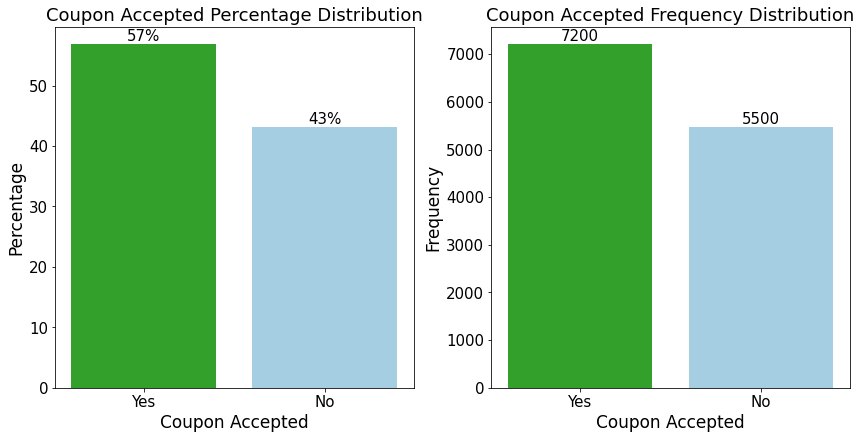

time: 287 ms (started: 2023-01-18 15:02:01 -08:00)


In [28]:
bar_orientation='vertical'
dpi=100
figure_filename = '../reports/figures/figure_coupon_accepted_percentage_and_frequency_distribution_'+ str(bar_orientation) + '_bar_plot_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'
figure_filename_axes1 = '../reports/figures/figure_coupon_accepted_percentage_and_frequency_distribution_'+ str(bar_orientation) + '_bar_plot_axes1_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'
figure_filename_axes2 = '../reports/figures/figure_coupon_accepted_percentage_and_frequency_distribution_'+ str(bar_orientation) + '_bar_plot_axes2_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

plot_save_together_separate = 'together'

figsize=(12, 6.2)
bar_width=0.8

xlabel = 'Coupon Accepted'
ylabel = 'Percentage'
title = 'Coupon Accepted '+ str(ylabel) + ' Distribution'

target_value_dictionary = {1: 'Yes', 0:'No'}

df_Y_frequency = df.loc[:, ['Y']].value_counts().reset_index().rename(columns={0:'frequency'})
df_Y_frequency.loc[:, 'percentage'] = df_Y_frequency.loc[:, 'frequency'] / df_Y_frequency.loc[:, 'frequency'].sum(axis=0) * 100
df_Y_frequency_percentage = df_Y_frequency
del df_Y_frequency

x_label_list = df_Y_frequency_percentage.loc[:, 'Y'].replace(target_value_dictionary).to_list()


if plot_save_together_separate == 'together':
    figure, (axes1, axes2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
elif plot_save_together_separate == 'separate':
    figure1, axes1 = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    figure2, axes2 = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    

#make percentage subplot
annotation_round_by_number = 0

percentage_list = df_Y_frequency_percentage.loc[:, 'percentage'].to_list()

axes1.bar(x=x_label_list, height=percentage_list, width=bar_width, color=[color_list[3], color_list[0]])

axes1.set_title(label=title, fontsize=18)
axes1.set_xlabel(xlabel=xlabel, fontsize=17)
axes1.set_ylabel(ylabel=ylabel, fontsize=17)
axes1.tick_params(axis='both', which='major', labelsize=15)

for rectangle, annotation in zip(axes1.patches, percentage_list):
    axes1.text(rectangle.get_x() + rectangle.get_width() / 2, rectangle.get_height(), format(round(annotation, annotation_round_by_number), '.0f') + '%', ha="center", va="bottom", fontsize=15)

#make frequency subplot
ylabel = 'Frequency'
title = 'Coupon Accepted '+ str(ylabel) + ' Distribution'
annotation_round_by_number = -2

frequency_list = df_Y_frequency_percentage.loc[:, 'frequency'].to_list()

axes2.bar(x=x_label_list, height=frequency_list, width=bar_width, color=[color_list[3], color_list[0]])

axes2.set_title(label=title, fontsize=18)
axes2.set_xlabel(xlabel=xlabel, fontsize=17)
axes2.set_ylabel(ylabel=ylabel, fontsize=17)
axes2.tick_params(axis='both', which='major', labelsize=15)

for rectangle, annotation in zip(axes2.patches, frequency_list):
    axes2.text(rectangle.get_x() + rectangle.get_width() / 2, rectangle.get_height() + 5, round(annotation, annotation_round_by_number), ha="center", va="bottom", fontsize=15)

plt.tight_layout()

if plot_save_together_separate == 'together':
    figure.savefig(figure_filename, bbox_inches='tight', dpi=dpi)
elif plot_save_together_separate == 'separate':
    figure1.savefig(figure_filename_axes1, bbox_inches='tight', dpi=dpi)
    figure2.savefig(figure_filename_axes2, bbox_inches='tight', dpi=dpi)


plt.show()

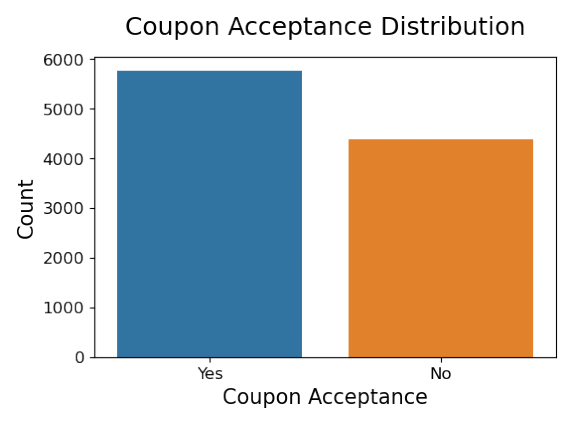

time: 75 ms (started: 2023-01-18 15:02:01 -08:00)


In [29]:
dpi=100
figure_filename = '../reports/figures/figure_target_variable_bar_plot_v3_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)

else:
    #get Y_train data
    _, _, Y_train_plot, _ = train_test_split(df.drop(columns=['Y']), df.loc[:, 'Y'], test_size=.2, random_state=200)

    #get Y_train coupon accepted and not accepted count
    df_target_plot = Y_train_plot.replace({0:'No', 1:'Yes'}).value_counts().to_frame().reset_index().rename(columns={'index':'accepted_not_accepted','Y':'count'})

    axes_object = sns.barplot(data=df_target_plot, x='accepted_not_accepted', y='count')
    axes_object.set_title('Coupon Acceptance Distribution', fontdict={'fontsize':18}, pad=16)
    #axes_object.set(xlabel='Coupon Acceptance', ylabel='Count')
    plt.xlabel('Coupon Acceptance', fontsize=15)
    plt.ylabel('Count', fontsize=15)
    plt.tick_params(labelsize=12)



    #save it
    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)
    
plt.show()

In [30]:
#sample size, population size, margin of error, confidence interval

#intialize parameters
z_score = 1.96; confidence_interval = .95

p_value = 0.5684326710816777
margin_of_error = .0381
N_population_size = 2.4 * 10**8

#known 652 surveys accepted, https://jmlr.org/papers/volume18/16-003/16-003.pdf

#calculate sample size
sample_size = (z_score**2*p_value*(1-p_value)/margin_of_error**2)/(1+(z_score**2*p_value*(1-p_value)/margin_of_error**2/N_population_size))
print('Sample size ' + str(round(sample_size)) + ' for a '+ str(round(confidence_interval*100, None)) +'% confidence interval, margin or error ' \
      + str(margin_of_error) + ', population size ' + str(round(N_population_size)) + ', p-value ' + str(round(p_value, 5))
      + ' is less than known 652 surveys.\n')

round_by_number = None
print('Therefore, '+ str(round(confidence_interval*100, None)) +'% of the time, we expect a coupon acceptance rate between ' \
      + str(round((p_value-margin_of_error/2)*100, round_by_number)) + '% and ' \
      + str(round((p_value+margin_of_error/2)*100, round_by_number)) + '%')

Sample size 649 for a 95% confidence interval, margin or error 0.0381, population size 240000000, p-value 0.56843 is less than known 652 surveys.

Therefore, 95% of the time, we expect a coupon acceptance rate between 55% and 59%
time: 1.38 ms (started: 2023-01-18 15:02:01 -08:00)


In [31]:
#sample size, population size, margin of error, confidence interval

#intialize parameters
z_score = 1.645; confidence_interval = .90

p_value = 0.5684326710816777
margin_of_error = .032
N_population_size = 2.4 * 10**8

#known 652 surveys accepted, https://jmlr.org/papers/volume18/16-003/16-003.pdf

#calculate sample size
sample_size = (z_score**2*p_value*(1-p_value)/margin_of_error**2)/(1+(z_score**2*p_value*(1-p_value)/margin_of_error**2/N_population_size))
print('Sample size ' + str(round(sample_size)) + ' for a '+ str(round(confidence_interval*100, None)) +'% confidence interval, margin or error ' \
      + str(margin_of_error) + ', population size ' + str(round(N_population_size)) + ', p-value ' + str(round(p_value, 5))
      + ' is less than known 652 surveys.\n')

round_by_number = None
print('Therefore, '+ str(round(confidence_interval*100, None)) + '% of the time, we expect a coupon acceptance rate between ' \
      + str(round((p_value-margin_of_error/2)*100, round_by_number)) + '% and ' \
      + str(round((p_value+margin_of_error/2)*100, round_by_number)) + '%')


Sample size 648 for a 90% confidence interval, margin or error 0.032, population size 240000000, p-value 0.56843 is less than known 652 surveys.

Therefore, 90% of the time, we expect a coupon acceptance rate between 55% and 58%
time: 2.08 ms (started: 2023-01-18 15:02:01 -08:00)


In [32]:
#survey coupon acceptance rate
df_Y_proportion = (df.groupby(['Y'])['Y'].agg('count') / df.shape[0])
df_Y_proportion[1]

0.5684326710816777

time: 3.54 ms (started: 2023-01-18 15:02:01 -08:00)


#### Coupon Acceptance Rate Per Feature Value Combination

In [33]:
#age, income, coffee house visit frequency --> coupon acceptace rate
df.loc[df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].isin([2, 5]) &
       df.loc[:, 'age'].isin(['21-25', '26-30', '50+']) &
       df.loc[:, 'income'].isin(['\\$50000 - \\$62499']), :]

,destination,passenger,weather,temperature,time,coupon_venue_type,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,Y,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding,CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding,CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding,RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding,Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding,Bar_venue_visit_frequency_no_response_indicator,CoffeeHouse_venue_visit_frequency_no_response_indicator,CarryAway_venue_visit_frequency_no_response_indicator,RestaurantLessThan20_venue_visit_frequency_no_response_indicator,Restaurant20To50_venue_visit_frequency_no_response_indicator
431,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,21-25,Single,0,Bachelors degree,Computer & Mathematical,\$50000 - \$62499,no response,1-3,<1,<1,never,never,0,0,1,1,2,10,23,56249.5,1,0,1,5,5,2,2,3,3,2,2,1,1,0,0,0,0,0
5743,No Urgent Place,Friend(s),Sunny,80,2PM,Restaurant(<20),2h,Male,21-25,Married partner,1,Some college - no degree,Computer & Mathematical,\$50000 - \$62499,no response,1-3,<1,<1,never,<1,1,0,1,1,2,14,23,56249.5,1,0,4,3,5,2,3,3,3,2,2,1,2,0,0,0,0,0
5395,No Urgent Place,Friend(s),Sunny,55,2PM,Coffee House,1d,Female,21-25,Unmarried partner,0,Bachelors degree,Education&Training&Library,\$50000 - \$62499,no response,<1,<1,<1,<1,<1,0,0,1,1,24,14,23,56249.5,0,1,1,5,5,2,3,2,2,2,2,2,2,0,0,0,0,0
1354,No Urgent Place,Partner,Sunny,80,10AM,Coffee House,2h,Male,21-25,Unmarried partner,0,Some college - no degree,Sales & Related,\$50000 - \$62499,no response,<1,>8,no response,<1,<1,0,0,1,1,2,10,23,56249.5,1,0,1,3,5,2,2,3,2,5,0,2,2,0,0,1,0,0
1362,Home,Alone,Sunny,80,6PM,Coffee House,2h,Male,21-25,Unmarried partner,0,Some college - no degree,Sales & Related,\$50000 - \$62499,no response,<1,>8,no response,<1,<1,0,0,1,1,2,18,23,56249.5,1,0,1,3,5,2,4,3,2,5,0,2,2,0,0,1,0,0
8582,Work,Alone,Sunny,80,7AM,Restaurant(<20),1d,Female,26-30,Married partner,1,Associates degree,Unemployed,\$50000 - \$62499,no response,1-3,<1,<1,<1,<1,0,0,0,1,24,7,28,56249.5,0,1,4,4,5,3,1,3,3,2,2,2,2,0,0,0,0,0
1352,No Urgent Place,Friend(s),Sunny,80,6PM,Restaurant(<20),2h,Male,21-25,Unmarried partner,0,Some college - no degree,Sales & Related,\$50000 - \$62499,no response,<1,>8,no response,<1,<1,1,0,1,1,2,18,23,56249.5,1,0,4,3,5,2,4,3,2,5,0,2,2,0,0,1,0,0
2810,No Urgent Place,Friend(s),Sunny,55,2PM,Coffee House,2h,Male,50+,Single,0,Some college - no degree,Student,\$50000 - \$62499,no response,1-3,<1,>8,>8,never,0,0,1,1,2,14,56,56249.5,1,0,1,3,5,8,3,2,3,2,5,5,1,0,0,0,0,0
2812,No Urgent Place,Alone,Sunny,55,10AM,Coffee House,2h,Male,50+,Single,0,Some college - no degree,Student,\$50000 - \$62499,no response,1-3,<1,>8,>8,never,0,0,1,1,2,10,56,56249.5,1,0,1,3,5,8,2,2,3,2,5,5,1,0,0,0,0,0
11371,No Urgent Place,Friend(s),Sunny,30,10AM,Carry out & Take away,2h,Female,26-30,Married partner,1,Associates degree,Unemployed,\$50000 - \$62499,no response,1-3,<1,<1,<1,<1,0,0,1,1,2,10,28,56249.5,0,0,3,4,5,3,2,1,3,2,2,2,2,0,0,0,0,0


time: 202 ms (started: 2023-01-18 15:02:01 -08:00)


In [34]:
age_list = ['21-25', '26-30', '50+']
coffee_house_monthly_visit_frequency_encoding_list = [2]
income_list = ['\\$50000 - \\$62499']

df.loc[df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].isin(coffee_house_monthly_visit_frequency_encoding_list) &
       df.loc[:, 'age'].isin(age_list) &
       df.loc[:, 'income'].isin(income_list), :].value_counts('Y')[1] / \
df.loc[df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].isin(coffee_house_monthly_visit_frequency_encoding_list) &
       df.loc[:, 'age'].isin(age_list) &
       df.loc[:, 'income'].isin(income_list), :].shape[0]



0.6753246753246753

time: 11.8 ms (started: 2023-01-18 15:02:02 -08:00)


In [35]:
age_list = ['21-25', '26-30', '50+']
coffee_house_monthly_visit_frequency_encoding_list = [2,5]
income_list = ['\\$50000 - \\$62499']


df_filtered = \
df.loc[df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].isin(coffee_house_monthly_visit_frequency_encoding_list) &
       df.loc[:, 'age'].isin(age_list) &
       df.loc[:, 'income'].isin(income_list), :]

number_of_coupons_accepted = df_filtered.value_counts('Y')[1]
print(number_of_coupons_accepted)
number_of_coupons_recommended = df_filtered.shape[0]
print(number_of_coupons_recommended)

coupon_acceptance_rate = number_of_coupons_accepted/number_of_coupons_recommended
print(coupon_acceptance_rate)

print(number_of_coupons_recommended)



255
374
0.6818181818181818
374
time: 5.16 ms (started: 2023-01-18 15:02:02 -08:00)


In [36]:
#^--- our model does something similar but it actually models better for coupon acceptance rate. likely because it's a better model, 
#     but also because it uses more features


#it's less about narrowing down by demogrpahics and more about coupon acceptance rate (i.e. conversion rate) then???

#run a final model with the least number of features??





time: 872 µs (started: 2023-01-18 15:02:02 -08:00)


In [37]:
income_list = ['\\$62500 - \\$74999', '\\$75000 - \\$87499', '\\$87500 - \\$99999']
age_list = ['<21', '31-35', '36-40', '41-45', '46-49'] #
coffee_house_monthly_visit_frequency_encoding_list = [3, 4, 1, 0] #0

df_filtered = \
df.loc[~df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].isin(coffee_house_monthly_visit_frequency_encoding_list) &
       ~df.loc[:, 'age'].isin(age_list) &
       ~df.loc[:, 'income'].isin(income_list), :]

number_of_coupons_accepted = df_filtered.value_counts('Y')[1]
print(number_of_coupons_accepted)
number_of_coupons_recommended = df_filtered.shape[0]
print(number_of_coupons_recommended)

coupon_acceptance_rate = number_of_coupons_accepted/number_of_coupons_recommended
print(coupon_acceptance_rate)

print(number_of_coupons_recommended)



1400
2064
0.6782945736434108
2064
time: 9.31 ms (started: 2023-01-18 15:02:02 -08:00)


In [38]:
income_list = ['\\$62500 - \\$74999', '\\$75000 - \\$87499', '\\$87500 - \\$99999']
age_list = ['<21', '31-35', '36-40', '41-45', '46-49']
coffee_house_monthly_visit_frequency_encoding_list = [3, 4, 1, 0] #0

number_of_coupon_accepted = \
df.loc[~df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].isin(coffee_house_monthly_visit_frequency_encoding_list) &
       ~df.loc[:, 'age'].isin(age_list) &
       ~df.loc[:, 'income'].isin(income_list), :].value_counts('Y')[1]
number_of_rows = \
df.loc[~df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].isin(coffee_house_monthly_visit_frequency_encoding_list) &
       ~df.loc[:, 'age'].isin(age_list) &
       ~df.loc[:, 'income'].isin(income_list), :].shape[0]

print(str(number_of_coupon_accepted/number_of_rows))

print(df.loc[~df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].isin(coffee_house_monthly_visit_frequency_encoding_list) &
       ~df.loc[:, 'age'].isin(age_list) &
       ~df.loc[:, 'income'].isin(income_list), :].shape[0])



0.6782945736434108
2064
time: 12 ms (started: 2023-01-18 15:02:02 -08:00)


In [39]:
def get_combinations_of_value_list(value_list):
    return [combination for combination_length in range(1, len(value_list) + 1) for combination in itertools.combinations(value_list, combination_length) ]

def get_value_combination_tuples_by_data_frame_and_column_name(df, column_name):
    column_name_value_list=df.loc[:, column_name].drop_duplicates().to_list()

    column_name_value_list_combinations=get_combinations_of_value_list(value_list=column_name_value_list)
    
    return column_name_value_list_combinations




time: 887 µs (started: 2023-01-18 15:02:02 -08:00)


In [40]:
feature_column_name_value_combination_tuple_list_collection={}

# get and add to collection coffee house venue visit frequency yes response ordinal encoding value combination tuple list
column_name='CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'
feature_column_name_value_combination_tuple_list_collection[column_name]=get_value_combination_tuples_by_data_frame_and_column_name(df=df, column_name=column_name)

# get and add to collection age value list combinations
column_name='age'
feature_column_name_value_combination_tuple_list_collection[column_name]=get_value_combination_tuples_by_data_frame_and_column_name(df=df, column_name=column_name)

# get and add to collection income value combination tuple list
column_name='income'
feature_column_name_value_combination_tuple_list_collection[column_name]=get_value_combination_tuples_by_data_frame_and_column_name(df=df, column_name=column_name)



time: 2.22 ms (started: 2023-01-18 15:02:02 -08:00)


In [42]:
key_list

dict_keys(['CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'age', 'income'])

time: 10.5 ms (started: 2023-01-18 15:02:53 -08:00)


In [44]:
key_list=list(feature_column_name_value_combination_tuple_list_collection.keys())

print(len(feature_column_name_value_combination_tuple_list_collection[key_list[0]]))
print(len(feature_column_name_value_combination_tuple_list_collection[key_list[1]]))
print(len(feature_column_name_value_combination_tuple_list_collection[key_list[2]]))

63
255
511
time: 888 µs (started: 2023-01-18 15:03:13 -08:00)


In [ ]:
feature_column_name_list=['CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'age', 'income']

value_metric_list_list=[]

for feature_0_column_name_value_combination_tuple in feature_column_name_value_combination_tuple_list_collection[feature_column_name_list[0]]:
    for feature_1_column_name_value_combination_tuple in feature_column_name_value_combination_tuple_list_collection[feature_column_name_list[1]]:
        for feature_2_column_name_value_combination_tuple in feature_column_name_value_combination_tuple_list_collection[feature_column_name_list[2]]:

            value_metric_list=[]

            #store column name value combination tuple
            value_metric_list+=[feature_0_column_name_value_combination_tuple, 
                                feature_1_column_name_value_combination_tuple, 
                                feature_2_column_name_value_combination_tuple]

            #filter target variable by feature column name value combination tuple
            df_filtered=df.loc[df.loc[:, feature_column_name_list[0]].isin(feature_0_column_name_value_combination_tuple) &
                               df.loc[:, feature_column_name_list[1]].isin(feature_1_column_name_value_combination_tuple) &
                               df.loc[:, feature_column_name_list[2]].isin(feature_2_column_name_value_combination_tuple), ['Y']]

            if df_filtered.empty != True:
                
                #get target variable unique value list
                target_variable_value_unique_list=df_filtered.loc[:, 'Y'].drop_duplicates().to_list()
            
                #initialize booleans coupon acceptance exists and coupon refusal exists
                coupon_acceptance_exists=True if 1 in target_variable_value_unique_list else False
                coupon_refusal_exists=True if 0 in target_variable_value_unique_list else False

                #get and add coupon acceptance rate
                if coupon_acceptance_exists==True:
                    value_metric_list+=[(df_filtered.value_counts()/df_filtered.shape[0])[1]]
                elif coupon_acceptance_exists==False:
                    value_metric_list+=[0]
                    

                #get and add coupon refusal rate
                if coupon_refusal_exists==True:
                    value_metric_list+=[(df_filtered.value_counts()/df_filtered.shape[0])[0]]
                elif coupon_refusal_exists==False:
                    value_metric_list+=[0]

                    
                #get and add coupons accepted
                if coupon_acceptance_exists==True:
                    value_metric_list+=[df_filtered.value_counts()[1]]
                elif coupon_acceptance_exists==False:
                    value_metric_list+=[0]
                    

                #get and add coupons refused
                if coupon_refusal_exists==True:
                    value_metric_list+=[df_filtered.value_counts()[0]]
                elif coupon_refusal_exists==False:
                    value_metric_list+=[0]
                

                #get and add coupons recommended
                value_metric_list+=[df_filtered.shape[0]]

            else:
                #coupon acceptance rate
                value_metric_list+=[None]

                #coupon refusal rate
                value_metric_list+=[None]

                #coupons accepted
                value_metric_list+=[0]

                #coupons refused
                value_metric_list+=[0]

                #coupons recommended
                value_metric_list+=[0]
                
            print(value_metric_list)    
            value_metric_list_list+=[value_metric_list]

value_metric_list_list

In [ ]:
column_name_list=feature_column_name_list+['Acceptance Rate', 'Refusal Rate', 'Coupons Accepted', 'Coupons Refused', 'Coupon Recommended']
column_name_list

In [ ]:
filename='df_feature_value_combination_tuple_metrics_v' + filename_version + '.pkl'

df_survey_metrics = pd.DataFrame(value_metric_list_list, columns=column_name_list)
df_survey_metrics

In [ ]:
column_name='CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'

value_metric_list_list=[]

for feature_column_name_value_combination_tuple in feature_column_name_value_combination_tuple_list_collection[column_name]:
    
    value_metric_list=[]
    
    #store column name value combination tuple
    value_metric_list+=[feature_column_name_value_combination_tuple]
    
    #filter target variable by feature column name value combination tuple
    df_filtered=df.loc[df.loc[:, column_name].isin(feature_column_name_value_combination_tuple), ['Y']]
    
    #coupon acceptance rate
    value_metric_list+=[(df_filtered.value_counts()/df_filtered.shape[0])[1]]

    #coupon refusal rate
    value_metric_list+=[(df_filtered.value_counts()/df_filtered.shape[0])[0]]
    
    #coupons accepted
    value_metric_list+=[df_filtered.value_counts()[1]]
    
    #coupons refused
    value_metric_list+=[df_filtered.value_counts()[0]]
    
    #coupons recommended
    value_metric_list+=[df_filtered.shape[0]]

    value_metric_list_list+=[value_metric_list]
    
value_metric_list_list

In [ ]:
#get combinations of values from features 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'age', 'income'

#filter data by feature combinations

#get survey metrics for filtered data frame


In [ ]:
def get_survey_metric_list_by_y_predicted_column_name(df_feature_column_name_unfiltered, df_feature_column_name_filtered, y_predicted_column_name, y_predicted_column_name_baseline, y_predicted_column_name_base_survey, y_actual_column_name):

    '''
    y_predicted_column_name_baseline: y_predicted from the survey number metric estimated'''

    metric_list=[]

    #get unfiltered y_true and y_predicted
    y_true_feature_column_name_filtered=df_feature_column_name_filtered.loc[:, y_actual_column_name]
    y_predicted_feature_column_name_filtered=df_feature_column_name_filtered.loc[:, y_predicted_column_name]

    #get filtered y_true and y_predicted
    y_true_feature_column_name_unfiltered=df_feature_column_name_unfiltered.loc[:, y_actual_column_name]
    y_predicted_feature_column_name_unfiltered=df_feature_column_name_unfiltered.loc[:, y_predicted_column_name]

    #get survey as a baseline y_predicted
    y_predicted_baseline_feature_column_name_filtered=df_feature_column_name_filtered.loc[:, y_predicted_column_name_baseline]

    #get base survey y_predicted
    y_predicted_base_survey_feature_column_name_filtered=df_feature_column_name_filtered.loc[:, y_predicted_column_name_base_survey]


    #get precision
    metric_list += [precision_score(y_true=y_true_feature_column_name_filtered, y_pred=y_predicted_feature_column_name_filtered)]

    #get recall
    metric_list += [recall_score(y_true=y_true_feature_column_name_filtered, y_pred=y_predicted_feature_column_name_filtered)]


    #tn, fp, fn, tp filtered
    confusion_matrix_ndarray_feature_column_name_filtered = confusion_matrix(y_true=y_true_feature_column_name_filtered, y_pred=y_predicted_feature_column_name_filtered)
    tn_feature_column_name_filtered, fp_feature_column_name_filtered, fn_feature_column_name_filtered, tp_feature_column_name_filtered = confusion_matrix_ndarray_feature_column_name_filtered.ravel()

    #tn, fp, fn, tp unfiltered
    confusion_matrix_ndarray_feature_column_name_unfiltered = confusion_matrix(y_true=df_feature_column_name_unfiltered.loc[:, y_actual_column_name], y_pred=df_feature_column_name_unfiltered.loc[:, y_predicted_column_name])
    tn_feature_column_name_unfiltered, fp_feature_column_name_unfiltered, fn_feature_column_name_unfiltered, tp_feature_column_name_unfiltered = confusion_matrix_ndarray_feature_column_name_unfiltered.ravel()

    #tn, fp, fn, tp baseline filtered
    confusion_matrix_ndarray_feature_column_name_filtered_baseline = confusion_matrix(y_true=y_true_feature_column_name_filtered, y_pred=y_predicted_baseline_feature_column_name_filtered)
    tn_feature_column_name_filtered_baseline, fp_feature_column_name_filtered_baseline, fn_feature_column_name_filtered_baseline, tp_feature_column_name_filtered_baseline = confusion_matrix_ndarray_feature_column_name_filtered_baseline.ravel()

    #tn, fp, fn, tp base survey filtered
    confusion_matrix_ndarray_feature_column_name_filtered_base_survey = confusion_matrix(y_true=y_true_feature_column_name_filtered, y_pred=y_predicted_base_survey_feature_column_name_filtered)
    tn_feature_column_name_filtered_base_survey, fp_feature_column_name_filtered_base_survey, fn_feature_column_name_filtered_base_survey, tp_feature_column_name_filtered_base_survey = confusion_matrix_ndarray_feature_column_name_filtered_base_survey.ravel()


    #get conversions proportion
    metric_list += [tp_feature_column_name_filtered/tp_feature_column_name_unfiltered]

    #get conversions
    metric_list += [tp_feature_column_name_filtered]

    #get coupons recommended proportion
    metric_list += [(tp_feature_column_name_filtered+fp_feature_column_name_filtered)/(tp_feature_column_name_unfiltered+fp_feature_column_name_unfiltered)]

    #get coupons recommended
    metric_list += [tp_feature_column_name_filtered+fp_feature_column_name_filtered]

    #get conversions to base survey coupons recommended ratio
    base_survey_coupons_recommended=tp_feature_column_name_filtered_base_survey+fp_feature_column_name_filtered_base_survey
    metric_list += [tp_feature_column_name_filtered/(base_survey_coupons_recommended)]

    #get conversions to survey conversions ratio
    metric_list += [(tp_feature_column_name_filtered)/(tp_feature_column_name_filtered_baseline)]

    #get conversions to base survey conversions ratio
    #metric_list += [(tp_feature_column_name_filtered)/(tp_feature_column_name_filtered_base_survey)]


    #get coupons recommended to survey coupons recommended ratio
    metric_list += [(tp_feature_column_name_filtered+fp_feature_column_name_filtered)/(tp_feature_column_name_filtered_baseline+fp_feature_column_name_filtered_baseline)]

    #get coupons recommended to base survey coupons recommended ratio
    metric_list += [(tp_feature_column_name_filtered+fp_feature_column_name_filtered)/(base_survey_coupons_recommended)]



    return metric_list


#get survey metric list
survey_metric_list=icr.get_model_or_survey_metric_list_by_y_predicted_column_name(df_feature_column_name_unfiltered=df, 
                                                                                  df_feature_column_name_filtered=df_feature_column_name_filtered, 
                                                                                  y_predicted_column_name=survey_number_recall_estimated_y_predicted_column_name, 
                                                                                  y_predicted_column_name_baseline=survey_number_recall_estimated_y_predicted_column_name, 
                                                                                  y_predicted_column_name_base_survey=y_predicted_column_name_base_survey, 
                                                                                  y_actual_column_name=y_actual_column_name)









#### Income Frequency Distribution (Vertical Bar Plot)

In [ ]:
feature_column_name = 'income'
feature_column_name_label='Income'
bar_orientation = 'vertical'

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_multiple_bar_coupon_accepted_coupon_refused_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

multibar_column_name_list=['coupon accepted', 'coupon refused']

feature_value_order_list = ['Less than \$12500', '\$12500 - \$24999', '\$25000 - \$37499', '\$37500 - \$49999', '\$50000 - \$62499', '\$62500 - \$74999',  '\$75000 - \$87499', '\$87500 - \$99999', '\$100000 or More',]

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]

xtick_rotation=90

x_upper_limit=None

if bar_orientation == 'vertical':
    figsize=(8,8)
    xlabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])
    
    icr.plot_vertical_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, xlabel=xlabel,color_list=color_list, figsize=figsize, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, xtick_rotation=xtick_rotation)

elif bar_orientation == 'horizontal':
    figsize=(8,6)
    ylabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=False).drop(columns=[str(feature_column_name)+'_rank'])

    icr.plot_horizontal_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, ylabel=ylabel, figsize=figsize, color_list=color_list, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, x_upper_limit=x_upper_limit)



#### Income Frequency Distribution (Horizontal Bar Plot)

In [ ]:
feature_column_name = 'income'
feature_column_name_label='Income'
bar_orientation = 'horizontal'

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_multiple_bar_coupon_accepted_coupon_refused_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

multibar_column_name_list=['coupon accepted', 'coupon refused']

feature_value_order_list = ['Less than \$12500', '\$12500 - \$24999', '\$25000 - \$37499', '\$37500 - \$49999', '\$50000 - \$62499', '\$62500 - \$74999',  '\$75000 - \$87499', '\$87500 - \$99999', '\$100000 or More',]

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]

x_upper_limit=1350

if bar_orientation == 'vertical':
    figsize=(8,8)
    xlabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])
    
    icr.plot_vertical_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, xlabel=xlabel,color_list=color_list, figsize=figsize, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, xtick_rotation=xtick_rotation)

elif bar_orientation == 'horizontal':
    figsize=(8,6)
    ylabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=False).drop(columns=[str(feature_column_name)+'_rank'])

    icr.plot_horizontal_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, ylabel=ylabel, figsize=figsize, color_list=color_list, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, x_upper_limit=x_upper_limit)



In [ ]:
feature_column_name = 'expiration'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'frequency'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['1d', '2h']
xtick_dictionary = {'1d':'1 day', '2h':'2 hours'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]


figsize=(8,8)


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number)



In [ ]:
df.loc[:, 'direction_same_or_opposite']

#### Coupon Venue Drive Direction Frequency Distribution (Stacked Bar Plot Percentage Annotation)

In [ ]:
feature_column_name = 'direction_same_or_opposite'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0,1]
xtick_dictionary = {0:'Same', 1:'Opposite'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit)



#### Expiration Frequency Distribution (Stacked Bar Plot Percentage Annotation)

In [ ]:
feature_column_name = 'expiration'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['1d', '2h']
xtick_dictionary = {'1d':'1 day', '2h':'2 hours'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit)



#### Gender Frequency Distribution (Stacked Bar Plot Percentage Annotation)

In [ ]:
feature_column_name = 'gender'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Female','Male', ]
xtick_dictionary = None

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=7500

figsize=(8,8)


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit)



#### Has Children Frequency Distribution (Vertical Bar Plot)

In [ ]:
feature_column_name = 'has_children'
feature_column_name_label='Has children'
bar_orientation = 'vertical'

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_multiple_bar_coupon_accepted_coupon_refused_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

multibar_column_name_list=['coupon accepted', 'coupon refused']

feature_value_order_list = [0, 1]
feature_value_dictionary = {0:'No', 1:'Yes'}

title= ' '.join([word.capitalize() for word in feature_column_name_label.split(' ')]) + ' Frequency Distribution'

color_index_list=[3,0]

xtick_rotation=0

if bar_orientation == 'vertical':
    figsize=(8,8)
    xlabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])
    
    icr.plot_vertical_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, xlabel=xlabel,color_list=color_list, figsize=figsize, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, xtick_rotation=xtick_rotation, feature_value_dictionary=feature_value_dictionary)

elif bar_orientation == 'horizontal':
    figsize=(8,6)
    ylabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=False).drop(columns=[str(feature_column_name)+'_rank'])

    icr.plot_horizontal_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, ylabel=ylabel, figsize=figsize, color_list=color_list, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, feature_value_dictionary=feature_value_dictionary)



In [ ]:
feature_column_name = 'toCoupon_GEQ15min'
feature_column_name_label='Drive time to coupon venue >15 minutes'
bar_orientation = 'vertical'

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_multiple_bar_coupon_accepted_coupon_refused_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

multibar_column_name_list=['coupon accepted', 'coupon refused']

feature_value_order_list = [0, 1]
feature_value_dictionary = {0:'No', 1:'Yes'}

title= 'Drive Time to Coupon Venue >15 Minutes' + ' Frequency Distribution'

color_index_list=[3,0]

xtick_rotation=0

if bar_orientation == 'vertical':
    figsize=(8,8)
    xlabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])
    
    icr.plot_vertical_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, xlabel=xlabel,color_list=color_list, figsize=figsize, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, xtick_rotation=xtick_rotation, feature_value_dictionary=feature_value_dictionary)

elif bar_orientation == 'horizontal':
    figsize=(8,6)
    ylabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=False).drop(columns=[str(feature_column_name)+'_rank'])

    icr.plot_horizontal_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, ylabel=ylabel, figsize=figsize, color_list=color_list, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, feature_value_dictionary=feature_value_dictionary)



#### Drive Time to Coupon Venue >25 Minutes Frequency Distribution (Vertical Bar Plot)

In [ ]:
feature_column_name = 'toCoupon_GEQ25min'
feature_column_name_label='Drive time to coupon venue >25 minutes' 
bar_orientation = 'vertical'

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_multiple_bar_coupon_accepted_coupon_refused_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

multibar_column_name_list=['coupon accepted', 'coupon refused']

feature_value_order_list = [0, 1]
feature_value_dictionary = {0:'No', 1:'Yes'}

title= 'Drive Time to Coupon Venue >25 Minutes' + ' Frequency Distribution'

color_index_list=[3,0]

xtick_rotation=0

if bar_orientation == 'vertical':
    figsize=(8,8)
    xlabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])
    
    icr.plot_vertical_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, xlabel=xlabel,color_list=color_list, figsize=figsize, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, xtick_rotation=xtick_rotation, feature_value_dictionary=feature_value_dictionary)

elif bar_orientation == 'horizontal':
    figsize=(8,6)
    ylabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=False).drop(columns=[str(feature_column_name)+'_rank'])

    icr.plot_horizontal_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, ylabel=ylabel, figsize=figsize, color_list=color_list, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, feature_value_dictionary=feature_value_dictionary)



#### Gender Frequency Distribution (Vertical Bar Plot)

In [ ]:
feature_column_name = 'gender'
feature_column_name_label='Gender'
bar_orientation = 'vertical'

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_multiple_bar_coupon_accepted_coupon_refused_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

multibar_column_name_list=['coupon accepted', 'coupon refused']

feature_value_order_list = [0, 1]
feature_value_dictionary = {0:'No', 1:'Yes'}

title= 'Gender' + ' Frequency Distribution'

color_index_list=[3,0]

xtick_rotation=0

if bar_orientation == 'vertical':
    figsize=(8,8)
    xlabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])
    
    icr.plot_vertical_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, xlabel=xlabel,color_list=color_list, figsize=figsize, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, xtick_rotation=xtick_rotation, feature_value_dictionary=feature_value_dictionary)

elif bar_orientation == 'horizontal':
    figsize=(8,6)
    ylabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=False).drop(columns=[str(feature_column_name)+'_rank'])

    icr.plot_horizontal_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, ylabel=ylabel, figsize=figsize, color_list=color_list, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, feature_value_dictionary=feature_value_dictionary)



In [ ]:
feature_column_name = 'income'
feature_column_name_label='Income'
bar_orientation = 'vertical'

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_multiple_bar_coupon_accepted_coupon_refused_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

multibar_column_name_list=['coupon accepted', 'coupon refused']

feature_value_order_list = ['Less than \$12500', '\$12500 - \$24999', '\$25000 - \$37499', '\$37500 - \$49999', '\$50000 - \$62499', '\$62500 - \$74999',  '\$75000 - \$87499', '\$87500 - \$99999', '\$100000 or More',]

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]

xtick_rotation=90

if bar_orientation == 'vertical':
    figsize=(8,8)
    xlabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])
    
    icr.plot_vertical_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, xlabel=xlabel,color_list=color_list, figsize=figsize, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, xtick_rotation=xtick_rotation)

elif bar_orientation == 'horizontal':
    figsize=(8,6)
    ylabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=False).drop(columns=[str(feature_column_name)+'_rank'])

    icr.plot_horizontal_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, ylabel=ylabel, figsize=figsize, color_list=color_list, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi)



In [ ]:
feature_column_name = 'income'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Percentage'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2
rectangle_annotation_y_offset = -45

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Less than \$12500', '\$12500 - \$24999', '\$25000 - \$37499', '\$37500 - \$49999', '\$50000 - \$62499', '\$62500 - \$74999',  '\$75000 - \$87499', '\$87500 - \$99999', '\$100000 or More',]
xtick_dictionary = None

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]


figsize=(8,8)


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, rectangle_annotation_y_offset=rectangle_annotation_y_offset)



#### Income Distribution (Vertical Bar Plot and Coupon Accepted Percentage Line Plot)

In [ ]:
feature_column_name='income'
feature_value_order_list = ['Less than \$12500', '\$12500 - \$24999', '\$25000 - \$37499', '\$37500 - \$49999', '\$50000 - \$62499', '\$62500 - \$74999',  '\$75000 - \$87499', '\$87500 - \$99999', '\$100000 or More',]


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])


title = 'Income Distribution'
frequency_ylabel = 'Frequency'
percentage_ylabel = 'Coupon Accepted Percentage'
xlabel = feature_column_name.capitalize()
bar_orientation = 'vertical'

bar_width=.7
figsize=(6,7)
frequency_ylim=None
percentage_ylim=None

dpi=100
figure_filename = '../reports/figures/figure_income_frequency_distribution_'+ str(bar_orientation) + '_bar_plot_and_percentage_line_chart_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure, (axes1, axes2) = plt.subplots(nrows=2, ncols=1, sharex='col', sharey='row', figsize=figsize)
axes1.bar(feature_value_order_list, df_income_coupon_accepted_coupon_refused.loc[:, 'total'].to_list(), width=bar_width, color=color_list[1])
axes2.plot(feature_value_order_list, df_income_coupon_accepted_coupon_refused.loc[:, 'percentage accepted'].to_list())

index_array = np.arange(len(feature_value_order_list))

axes1.set_title(title, fontsize=18)
axes1.set_ylabel(frequency_ylabel, fontsize=17)
axes2.set_ylabel(percentage_ylabel, fontsize=17)
axes2.set_xlabel(xlabel, fontsize=17)
axes2.set_xticks(ticks=index_array, labels=feature_value_order_list, rotation=90, fontsize=15)

axes1.set_ylim(frequency_ylim) if frequency_ylim != None else None
axes2.set_ylim(percentage_ylim) if percentage_ylim != None else None

plt.tight_layout()

plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()


In [ ]:
feature_column_name = 'destination'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['No Urgent Place', 'Work', 'Home']
xtick_dictionary = {'No Urgent Place':'No urgent place', 'Work':'Work', 'Home':'Home'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)
rectangle_annotation_y_offset = -100


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset)



In [ ]:
feature_column_name = 'passenger'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Alone', 'Friend(s)', 'Partner', 'Kid(s)', ]
xtick_dictionary = None

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)

rectangle_annotation_y_offset=-140

#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset)



In [ ]:
feature_column_name = 'weather'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Sunny', 'Snowy', 'Rainy', ]
xtick_dictionary = None

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)

rectangle_annotation_y_offset=-140

#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset)



In [ ]:
feature_column_name = 'time'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['7AM', '10AM', '2PM', '6PM', '10PM']
xtick_dictionary = None

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)

rectangle_annotation_y_offset=-80

#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset)



In [ ]:
feature_column_name = 'coupon_venue_type'
feature_column_name_label='Coupon Venue Type'#feature_column_name.capitalize()
xlabel='Coupon venue type'#feature_column_name_label
ylabel='Frequency'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Coffee House', 'Restaurant(<20)', 'Carry out & Take away', 'Bar', 'Restaurant(20-50)']
xtick_dictionary = {'Coffee House':'Coffee house', 'Restaurant(<20)':'Low-cost restaurant', 'Carry out & Take away':'Takeout', 'Bar':'Bar', 'Restaurant(20-50)':'Expensive restaurant'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-80

#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize)



In [ ]:
feature_column_name = 'age'
feature_column_name_label='Age Group'#feature_column_name.capitalize()
xlabel='Age'#feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['<21', '21-25', '26-30', '31-35', '36-40', '41-45', '46-49', '50+']
xtick_dictionary = None #{}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-40

#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize)



In [ ]:
feature_column_name = 'maritalStatus'
feature_column_name_label='Marital Status'#feature_column_name.capitalize()
xlabel='Marital status'#feature_column_name_label
ylabel='Frequency'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Married partner', 'Single', 'Unmarried partner', 'Divorced', 'Widowed']
xtick_dictionary = None #{}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)

rectangle_annotation_y_offset=-40

#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize)



In [ ]:
feature_column_name = 'education'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Some High School', 'High School Graduate', 'Some college - no degree', 'Associates degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)',]
xtick_dictionary = None #{}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)

rectangle_annotation_y_offset=-40

#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize)



In [ ]:
feature_column_name = 'occupation'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-1

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = \
['Unemployed', 'Student', 'Computer & Mathematical', 'Sales & Related', 'Education&Training&Library', 'Management', 
 'Office & Administrative Support', 'Arts Design Entertainment Sports & Media',
 'Business & Financial', 'Retired', 'Food Preparation & Serving Related', 'Healthcare Practitioners & Technical',
 'Healthcare Support', 'Community & Social Services', 'Legal', 'Transportation & Material Moving',
 'Architecture & Engineering', 'Personal Care & Service', 'Protective Service', 'Life Physical Social Science',
 'Construction & Extraction', 'Installation Maintenance & Repair', 'Production Occupations', 'Farming Fishing & Forestry',
 'Building & Grounds Cleaning & Maintenance']

xtick_dictionary = None #{}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(19,10)

rectangle_annotation_y_offset=-20


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)



In [ ]:
feature_column_name = 'occupation'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Building & Grounds Cleaning & Maintenance', 'Farming Fishing & Forestry', 'Production Occupations', 'Installation Maintenance & Repair', 'Construction & Extraction', 'Life Physical Social Science', 'Protective Service', 'Personal Care & Service', 'Architecture & Engineering', 'Transportation & Material Moving', 'Legal', 'Community & Social Services', 'Healthcare Support', 'Healthcare Practitioners & Technical', 'Food Preparation & Serving Related', 'Retired', 'Business & Financial', 'Arts Design Entertainment Sports & Media', 'Office & Administrative Support', 'Management', 'Education&Training&Library', 'Sales & Related', 'Computer & Mathematical', 'Student', 'Unemployed']
xtick_dictionary = None #{}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

x_upper_limit=None

figsize=(12,10)

rectangle_annotation_y_offset=-0.21
annotation_text_size=13


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)


icr.plot_horizontal_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, figsize=figsize, rectangle_annotation_y_offset=rectangle_annotation_y_offset, annotation_text_size=annotation_text_size, x_upper_limit=x_upper_limit, color_list=color_list, title=title)




#### Bar Monthly Visit Frequency Frequency Distribution

In [ ]:
icr.reverse_key_value_of_dictionary({'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0})


In [ ]:
feature_column_name = 'Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding'
feature_column_name_label='Bar Monthly Visits'
xlabel='Bar monthly visits'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0, 1, 2, 3, 4, 5]
xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)



In [ ]:
feature_column_name = 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'
feature_column_name_label='Coffee House Monthly Visits'
xlabel='Coffee house monthly visits'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0, 1, 2, 3, 4, 5]
xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)



In [ ]:
feature_column_name = 'CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding'
feature_column_name_label='Takeout Monthly Visits'
xlabel='Takeout monthly visits'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0, 1, 2, 3, 4, 5]
xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)



In [ ]:
feature_column_name = 'RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding'
feature_column_name_label='Low-Cost Restaurant Monthly Visits'
xlabel='Low-cost restaurant monthly visits'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0, 1, 2, 3, 4, 5]
xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)



In [ ]:
feature_column_name = 'Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding'
feature_column_name_label='Expensive Restaurant Monthly Visits'
xlabel='Expensive restaurant monthly visits'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0, 1, 2, 3, 4, 5]
xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)



In [ ]:
feature_column_name = 'temperature_ordinal_integer_encoding'
feature_column_name_label='Temperature'
xlabel='Temperature (F)'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [1, 2, 3,]
xtick_dictionary = {1: 30, 2: 55, 3: 80,}


title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)



#### Venue Monthly Visits Frequency Distribution

In [ ]:
column_name_list = ['Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding',]

df_bar_coffee_house_takeout_low_cost_restaurant_expensive_restaurant_monthly_visits_frequency = df.loc[:, column_name_list].apply(pd.Series.value_counts).reset_index().rename(columns={'index':'feature_value'})
df_bar_coffee_house_takeout_low_cost_restaurant_expensive_restaurant_monthly_visits_frequency


In [ ]:
name1='venue_monthly_visits'
bar_orientation = 'vertical'

dpi=100
figure_filename = '../reports/figures/figure_'+ str(name1) +'_frequency_distribution_'+ str(bar_orientation) + 'multibar_plot_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

multibar_column_name_list=['Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding']

bar_label_list = ['Bar', 'Coffee House', 'Takeout', 'Low-cost restaurant', 'Expensive Restaurant']


xlabel_column_name='feature_value'
feature_value_order_list = [0, 1, 2, 3, 4, 5]

xlabel='Venue monthly visits'


title= ''.join([word.capitalize() + ' ' for word in xlabel.split(' ')]) + 'Frequency Distribution'

xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

color_index_list=[0, 1, 2, 3, 4, 5]

xtick_rotation=0

x_upper_limit=None

figsize=(9,9)


if bar_orientation == 'vertical':
    
    icr.plot_vertical_multibar_bar_graph(df=df_bar_coffee_house_takeout_low_cost_restaurant_expensive_restaurant_monthly_visits_frequency, xlabel_column_name=xlabel_column_name, multibar_column_name_list=multibar_column_name_list, title=title, xlabel=xlabel,color_list=color_list, figsize=figsize, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, bar_label_list=bar_label_list)



In [ ]:
color_list[0:6]

### Initialize Plot Variables

In [ ]:
title_fontsize=16
dpi=100
color_list = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
#color_list = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999']
#color_list =  ['red', 'green', 'blue', 'skyblue', 'yellow', 'purple', 'orange', 'pink', 'yellowgreen']
circle_color='white'


### Income Donut Plot

In [ ]:
column_name='income'
title = 'Income Donut Plot'
figure_filename = '../reports/figures/figure_donut_plot_' + column_name + '_value_count_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

name_list = ['\$25000 - \$37499', '\$12500 - \$24999', '\$37500 - \$49999', '\$100000 or More', '\$50000 - \$62499', 'Less than \$12500', '\$87500 - \$99999', '\$75000 - \$87499', '\$62500 - \$74999']
size_list = [2013, 1831, 1805, 1736, 1659, 1042,  895,  857,  846]

icr.donut_plot(name_list, size_list, title=title, title_fontsize=title_fontsize, figure_filename=figure_filename, dpi=dpi, color_list=color_list, circle_color=circle_color)



### Age Donut Plot

In [ ]:
column_name = 'age'
title = 'Age Donut Plot'

figure_filename = '../reports/figures/figure_' + column_name +'_plot_income_value_count_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

name_list = ['26-30', '21-25', '31-35', '36-40', '<21', '41-45', '46-49', '50+']
size_list = [2653, 2559, 2039, 1788, 1319, 1093,  686,  547]

icr.donut_plot(name_list, size_list, title=title, title_fontsize=title_fontsize, figure_filename=figure_filename, dpi=dpi, color_list=color_list, circle_color=circle_color)



### Monthly Coffee House Visit Frequency

In [ ]:
df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].value_counts().values

In [ ]:
coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_dencoding = {value : key for key, value in coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_encoding['CoffeeHouse'].items()}
pdc(coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_dencoding)

In [ ]:
column_name='monthly_coffee_house_visit_frequency'
title = 'Monthly Coffee House Visit Frequency Donut Plot'
#title = 'Yes Response: Monthly Coffee House Visit Frequency Donut Plot'

figure_filename = '../reports/figures/figure_donut_plot_' + column_name + '_value_count_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

name_list = ['never', '<1', '1-3', '>8', 'no response', '4-8']
size_list = [3385, 3225, 2962, 1784, 1111,  217]

icr.donut_plot(name_list, size_list, title=title, title_fontsize=title_fontsize, figure_filename=figure_filename, dpi=dpi, color_list=color_list, circle_color=circle_color)



In [ ]:
column_name='monthly_coffee_house_visit_frequency_encoding'
title = 'Monthly Coffee House Visit Frequency Donut Plot'
#title = 'Yes Response: Monthly Coffee House Visit Frequency Donut Plot'

figure_filename = '../reports/figures/figure_donut_plot_' + column_name + '_value_count_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

name_list = ['1 : never', '2 : <1', '3 : 1-3', '5 : >8', '0 : no response', '4 : 4-8']
size_list = [3385, 3225, 2962, 1784, 1111,  217]

icr.donut_plot(name_list, size_list, title=title, title_fontsize=title_fontsize, figure_filename=figure_filename, dpi=dpi, color_list=color_list, circle_color=circle_color)



In [ ]:
#correlation heatmap
dpi=100
figure_filename = '../reports/figures/figure_triangle_correlation_heatmap_random_forest_classifier_numerics_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)

if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(30, 24))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)

else:
    plt.figure(figsize=(30, 24))
    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()

In [ ]:
#save preprocessed data frame
df_collection_filename='df_collection_train_test_v' + filename_version + '.pkl'


df_readback = icr.return_processed_collection_if_it_exists(filename=df_collection_filename)
if df_readback != None:
    df_collection = df_readback
else:
    df_collection = {}
    
    #split the data into train and test
    df_collection['X_train'], df_collection['X_test'], df_collection['Y_train'], df_collection['Y_test'] = \
    train_test_split(df.drop(columns=['Y']), df.loc[:, 'Y'], test_size=.2, random_state=200)
    
    #save preprocessed data frame collection
    df_collection = icr.save_and_return_collection(data_frame_collection=df_collection, filename=df_collection_filename)

p(df_collection['X_train'])

## Get Stratified Train Data Frame Collection Before Data Preprocesssing

In [ ]:
StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

stratified_fold_number_X_train_X_test_Y_train_Y_test_df_collection = {}


for index, (train_index, test_index) in enumerate(StratifiedKFold_5_splits.split(X=df_collection['X_train'], y=df_collection['Y_train'].to_frame())):
    print('fold ' + str(index) + " TRAIN:", train_index, "TEST:", test_index)
    stratified_fold_number_X_train_X_test_Y_train_Y_test_df_collection['fold ' + str(index)] = \
    {'X_train' : df_collection['X_train'].iloc[train_index, :], \
     'X_test' : df_collection['X_train'].iloc[test_index, :], \
     'Y_train' : df_collection['Y_train'].iloc[train_index], \
     'Y_test' : df_collection['Y_train'].iloc[test_index]}

#use .loc for selection by index label, .iloc for selection by index location

print()
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_df_collection['fold 0']['X_test'])



In [ ]:
data_frame_list = [stratified_fold_number_X_train_X_test_Y_train_Y_test_df_collection['fold ' + str(index)]['X_test'] for index in range(5)]

df_stratified_fold_number_X_test = pd.concat(data_frame_list)

p(df_stratified_fold_number_X_test)

<font size="5"><a id='[Data_Preprocessing]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Data_Preprocessing]'>**Data Preprocessing**</a> </font>

## Convert Indicator Variables from Categorical Variables and Add Back to Numeric Variables

In [ ]:
#get column name lists
column_name_list_numeric = list(df.select_dtypes('number').columns)
column_name_list_not_numeric = [column_name for column_name in df.columns if not column_name in column_name_list_numeric]

#get categorical features, numeric features, and target data frame
df_categorical_features = df.loc[:, column_name_list_not_numeric]
df_numeric_features = df.loc[:, column_name_list_numeric].drop(columns='Y')
df_target = df.loc[:, ['Y']]

#get category indicators data frame from df_categorical_features
df_category_indicator_features = pd.get_dummies(df_categorical_features)

del df_categorical_features

#combine category indicator features and numeric features
df_indicator_numeric_features = pd.concat([df_category_indicator_features, df_numeric_features], axis=1)

del df_numeric_features, 

p(df_indicator_numeric_features)


## Get Data Frame Collection With Train and Test Features

In [ ]:
data_frame_collection_filename='data_frame_collection_train_test_v' + filename_version + '.pkl'

df_readback = icr.return_processed_collection_if_it_exists(filename=data_frame_collection_filename, parse_dates=False)
if df_readback != None:
    data_frame_collection = df_readback
else:
    data_frame_collection = {}

    #split the data into train and test
    data_frame_collection['X_train'], data_frame_collection['X_test'], data_frame_collection['Y_train'], data_frame_collection['Y_test'] = \
    train_test_split(df_indicator_numeric_features, df_target, test_size=.2, random_state=200)

    del df_indicator_numeric_features

    #save preprocessed data frame collection
    data_frame_collection = icr.save_and_return_collection(data_frame_collection=data_frame_collection, filename=data_frame_collection_filename)

p(data_frame_collection['X_train'])


## Get Stratified 5-Fold Cross Validation X_train, X_test, Y_train, Y_test Collection

In [ ]:
#stratified 5-fold cross validation train-test data row selection

#Stratified 5-Fold object
StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

#get stratified 5-fold data frame splits
stratified_fold_number_X_train_X_test_Y_train_Y_test_collection = {}


for index, (train_index, test_index) in enumerate(StratifiedKFold_5_splits.split(data_frame_collection['X_train'], data_frame_collection['Y_train'].loc[:, 'Y'])):
    print('fold ' + str(index) + " TRAIN:", train_index, "TEST:", test_index)
    stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)] = \
    {'X_train' : data_frame_collection['X_train'].iloc[train_index, :], \
     'X_test' : data_frame_collection['X_train'].iloc[test_index, :], \
     'Y_train' : data_frame_collection['Y_train'].loc[:, 'Y'].iloc[train_index], \
     'Y_test' : data_frame_collection['Y_train'].loc[:, 'Y'].iloc[test_index]}

#use .loc for selection by index label, .iloc for selection by index location

print()
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['X_train'])

In [ ]:
#standardize and scale fold 0 thru 4 train and test sets

number_of_folds=5

for fold_number in range(number_of_folds):
    
    standard_scaler = StandardScaler()
    standardized_scaled_stratified_fold_number_X_train_ndarray=standard_scaler.fit_transform(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_train'])
    

    stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_train'] = \
    pd.DataFrame(standardized_scaled_stratified_fold_number_X_train_ndarray, 
                 columns=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_train'].columns, 
                 index=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_train'].index)
    
    
    standardized_scaled_stratified_fold_number_X_test_ndarray=standard_scaler.transform(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'])
    
    stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'] = \
    pd.DataFrame(standardized_scaled_stratified_fold_number_X_test_ndarray, 
                 columns=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'].columns, 
                 index=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'].index)

print()
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['X_test'])



## Standardize And Scale Features of Data Frame Collection

In [ ]:
data_frame_collection_filename='data_frame_collection_train_test_standardize_scale_v' + filename_version + '.pkl'


df_readback = icr.return_processed_collection_if_it_exists(filename=data_frame_collection_filename, parse_dates=False)
if df_readback != None:
    data_frame_collection = df_readback
else:
    #standardize and scale feature data frame
    standard_scaler = StandardScaler()
    standardized_scaled_data_frame_collection_X_train_ndarray = standard_scaler.fit_transform(data_frame_collection['X_train'])
    data_frame_collection['X_train'] = pd.DataFrame(standardized_scaled_data_frame_collection_X_train_ndarray, columns=data_frame_collection['X_train'].columns, index=data_frame_collection['X_train'].index)


    standardized_scaled_df_collection_X_test_ndarray = standard_scaler.transform(data_frame_collection['X_test'])
    data_frame_collection['X_test'] = pd.DataFrame(standardized_scaled_df_collection_X_test_ndarray, columns=data_frame_collection['X_test'].columns, index=data_frame_collection['X_test'].index)

    data_frame_collection = icr.save_and_return_collection(data_frame_collection=data_frame_collection, filename=data_frame_collection_filename)

    del standardized_scaled_data_frame_collection_X_train_ndarray, standardized_scaled_df_collection_X_test_ndarray, standard_scaler

print(data_frame_collection['X_train'].shape, data_frame_collection['X_test'].shape, data_frame_collection['Y_train'].shape, data_frame_collection['Y_test'].shape)
p(data_frame_collection['X_train'])

## Covert to Y Train Data Frame from Y Test Data Frame Collection

In [ ]:
#convert to y_actual data frame from y_actual data frame collection
data_frame_list_stratified_fold_number_Y_test = [stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(fold_number)]['Y_test'] for fold_number in range(5)]

df_stratified_fold_number_y_test = pd.concat(data_frame_list_stratified_fold_number_Y_test, axis=0, join='outer', ignore_index=False, copy=True).to_frame()
p(df_stratified_fold_number_y_test)

<font size="5"><a id='[Modeling]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Modeling]'>**Modeling**</a> </font>

## Initialize Filename & Results Collection Variables

In [ ]:
classifier_name_list = ['random_forest_classifier', 'gradient_boosting_classifier']

#filename
grid_search_models_filename_collection={}
grid_search_models_local_optimum_filename_collection={}

model_filename_collection = {}
model_cross_validation_results_filename_collection = {}

cross_validation_model_collection_filename_collection = {}
model_cross_validation_prediction_probability_collection_filename_collection = {}
model_cross_validation_prediction_collection_filename_collection = {}

learning_curve_results_filename_collection = {}

for classifier_name in classifier_name_list:
    grid_search_models_filename_collection[classifier_name]='stratified_5_fold_grid_search_cross_validation_' + classifier_name + '_v' + filename_version + '.pkl'
    grid_search_models_local_optimum_filename_collection[classifier_name]='stratified_5_fold_grid_search_cross_validation_' + classifier_name + '_local_optimum_v' + filename_version + '.pkl'
    
    model_filename_collection[classifier_name]='best_stratified_5_fold_grid_search_cross_validation_'+ classifier_name + '_v' + filename_version + '.pkl'
    model_cross_validation_results_filename_collection[classifier_name]='best_' + classifier_name + '_stratified_5_fold_cross_validation_results_v' + filename_version + '.pkl'

    cross_validation_model_collection_filename_collection[classifier_name] = 'stratified_5_fold_cross_validation_' + str(classifier_name) + '_collection_v' + filename_version + '.pkl'
    model_cross_validation_prediction_probability_collection_filename_collection[classifier_name] = 'stratified_5_fold_cross_validation_' + str(classifier_name) + '_prediction_probability_collection_v' + filename_version + '.pkl'
    model_cross_validation_prediction_collection_filename_collection[classifier_name] = 'stratified_5_fold_cross_validation_' + str(classifier_name) + '_prediction_collection_v' + filename_version + '.pkl'
    
    learning_curve_results_filename_collection[classifier_name]='learning_curve_results_best_' + classifier_name + '_v' + filename_version + '.pkl'

random_forest_classifier_all_data_fit_filename = 'random_forest_classifier_all_data_fit_v' + filename_version + '.pkl'
    
model_version=filename_version

## Initialize Other Variables

In [ ]:
StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection = {}

stratified_5_fold_cross_validation_model_classifier_prediction_probability_data_frame_collection = {}

#stratified_5_fold_cross_validation_model_classifier_decision_threshold_prediction_data_frame_collection = {}

stratified_5_fold_cross_validation_model_classifier_prediction_data_frame_collection = {}

model_stratified_5_fold_cross_validation_results_collection = {}



<font size="5"><a id='[Modeling_1]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Modeling_1]'>**Modeling 1**</a> </font>

## Get Random Forest Classifier Stratified 5-Fold Cross Validation Grid Search by Accuracy

In [ ]:
#get grid search stratified 5-fold cross validation results
models_readback = icr.return_saved_model_if_it_exists(filename=grid_search_models_filename_collection['random_forest_classifier'])
if models_readback != None:
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier = models_readback
else:
    #random forest hyperparameter tuning using 5-fold cross validation

    # Create the parameter grid based on the results of random search
    param_grid = {
        'n_estimators': [200], #more is better, otherwise these are just random variation
        'criterion':['gini'],
        'max_depth': [3, 5, 10, 20, 25, None], #ba 3, past 25 is a lot (and can be left to whatever large max depth then); previously [5, 10, 20, 25, 30, 35, 40]
        'min_samples_split': [1, 10, 50, 100], #ba 1, 10, 50, 100; previously [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
        'min_samples_leaf':[1],
        'min_weight_fraction_leaf':[0.0],
        'max_features':['auto'],
        'max_leaf_nodes':[None],
        'min_impurity_decrease':[0.0],
        'bootstrap': [False ,True],
        'oob_score': [False],
        'n_jobs': [None],
        'warm_start':[False],
        'class_weight':[None],
        'ccp_alpha':[0.0],
        'max_samples':[None],
    }
    
    #RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=4,
                       #n_estimators=200, random_state=200)

    # Create a base model
    random_forest_classifier = RandomForestClassifier(random_state=200)

    # Instantiate the Stratified 5-Fold Grid Search Cross Validation
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier = GridSearchCV(estimator=random_forest_classifier, 
                                                                                           param_grid=param_grid, 
                                                                                           cv=StratifiedKFold_5_splits,
                                                                                           n_jobs=-1, 
                                                                                           verbose=0,
                                                                                           scoring=None)
    # Fit the grid search to the data
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier.fit(data_frame_collection['X_train'], data_frame_collection['Y_train'].loc[:, 'Y'])

    #save it
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier = icr.save_and_return_model(stratified_5_fold_grid_search_cross_validation_random_forest_classifier, 
                                                                                                        filename=grid_search_models_filename_collection['random_forest_classifier'])

stratified_5_fold_grid_search_cross_validation_random_forest_classifier

In [ ]:
stratified_5_fold_grid_search_cross_validation_random_forest_classifier.best_estimator_

## Get Random Forest Classifier Stratified 5-Fold Cross Validation Grid Search by Accuracy For Local Optimum

In [ ]:
models_readback = icr.return_saved_model_if_it_exists(filename=grid_search_models_local_optimum_filename_collection['random_forest_classifier'])
if models_readback != None:
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum = models_readback
else:
    #random forest hyperparameter tuning using 5-fold cross validation
    param_grid = {
        'bootstrap': [False ,True],
        'criterion':['gini'],
        'max_features':['auto'],
        'max_depth': [3, 5, 10, 20, 25, None], # lower numbers reduce growth
        'min_samples_split': [1, 5, 10, 15, 20], # higher numbers reduce growth
        'min_samples_leaf':[1],
        'n_estimators': [200], #more is better, otherwise these are just random variation
        'warm_start':[False]
    }
    #min_samples_leaf can be used as an alternative to 'min_samples_split'

    
    # Create a base model
    random_forest_classifier = RandomForestClassifier(random_state=200)

    # Instantiate the Stratified 5-Fold Grid Search Cross Validation
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum = GridSearchCV(estimator=random_forest_classifier, 
                                                                                                         param_grid=param_grid, 
                                                                                                         cv=StratifiedKFold_5_splits,
                                                                                                         n_jobs=-1, 
                                                                                                         verbose=0,
                                                                                                         scoring=None)
    # Fit the grid search to the data
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum.fit(data_frame_collection['X_train'], data_frame_collection['Y_train'].loc[:, 'Y'])

    #save it
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum = icr.save_and_return_model(stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum, 
                                                                                                                      filename=grid_search_models_local_optimum_filename_collection['random_forest_classifier'])

#del stratified_5_fold_grid_search_cross_validation_random_forest_classifier
stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum


In [ ]:
stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum.best_estimator_

## Get Best Random Forest Classifier by Accuracy

In [ ]:
#get best random forest classifier
model_readback = icr.return_saved_model_if_it_exists(filename=model_filename_collection['random_forest_classifier'])
if model_readback != None:
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = model_readback
else:   
    #add model environment data to model

    #get best random forest classifier from grid search cross validation
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum.best_estimator_

    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.version = model_version
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.pandas_version = pd.__version__
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.numpy_version = np.__version__
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.sklearn_version = sklearn_version
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.X_columns = [column_name for column_name in data_frame_collection['X_train'].columns]
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.build_datetime = datetime.datetime.now()    

    
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = icr.save_and_return_model(best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier, 
                                                                                                              filename=model_filename_collection['random_forest_classifier'])
    
best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier


## Get Stratified 5-Fold Cross Validation Random Forest Classifier Collection

In [ ]:
models_readback = icr.return_saved_model_if_it_exists(filename=cross_validation_model_collection_filename_collection['random_forest_classifier'])
if models_readback != None:
    stratified_5_fold_cross_validation_random_forest_classifier_collection = models_readback
else:
    stratified_5_fold_cross_validation_random_forest_classifier_collection = {}
    for index in range(5):

        #create random forest classifier
        random_forest_classifier=RandomForestClassifier(bootstrap=False, 
                                                        max_depth=None, 
                                                        min_samples_split=10, 
                                                        n_estimators=200,
                                                        min_samples_leaf=1,
                                                        max_features='auto',
                                                        criterion='gini',
                                                        warm_start='False',
                                                        random_state=200)

        #train random forest classifier and save random forest classifer per fold
        random_forest_classifier.fit(X=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_train'],
                                     y=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['Y_train'])

        stratified_5_fold_cross_validation_random_forest_classifier_collection['fold ' + str(index)] = random_forest_classifier


    #save stratified 5-fold cross validation random forest classifier collection
    stratified_5_fold_cross_validation_random_forest_classifier_collection = icr.save_and_return_model(stratified_5_fold_cross_validation_random_forest_classifier_collection, 
                                                                                                       filename=cross_validation_model_collection_filename_collection['random_forest_classifier'])
stratified_5_fold_cross_validation_random_forest_classifier_collection



## Get Stratified 5-Fold Cross Validation Random Forest Classifier Prediction Probability Collection

In [ ]:
prediction_probability_ndarray_collection = icr.return_processed_collection_if_it_exists(filename=model_cross_validation_prediction_probability_collection_filename_collection['random_forest_classifier'])
if prediction_probability_ndarray_collection != None:
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection = prediction_probability_ndarray_collection
else:
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection = {}
    for index in range(5):
        #get predictions for test per fold
        stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection['fold ' + str(index)] = \
        stratified_5_fold_cross_validation_random_forest_classifier_collection['fold ' + str(index)]\
        .predict_proba(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'])
    

    #save stratified 5-fold cross validation random forest classifier prediction collection
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection = icr.save_and_return_collection(data_frame_collection=stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection, 
                                                                                                                                   filename=model_cross_validation_prediction_probability_collection_filename_collection['random_forest_classifier'])
stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection['fold 0']


## Get Stratified 5-Fold Cross Validation Random Forest Classifier Prediction Probability Series

In [ ]:
#get data frame list
data_frame_list_stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability = \
[pd.DataFrame(stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection['fold ' + str(number)]).loc[:, 1] for number in range(5)]

stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['random_forest_classifier'] = \
pd.concat(data_frame_list_stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability)

p(stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['random_forest_classifier'])



In [ ]:
import warnings
warnings.filterwarnings('ignore')

<font size="5"><a id='[Modeling_2]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Modeling_2]'>**Modeling 2**</a> </font>

## Get Gradient Boosting Classifier Stratified 5-Fold Grid Seach Cross Validation by Accuracy Score

In [ ]:
#get grid search stratified 5-fold cross validation results
models_readback = icr.return_saved_model_if_it_exists(filename=grid_search_models_filename_collection['gradient_boosting_classifier'])
if models_readback != None:
    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = models_readback
else:
    gradient_boosting_classifier = GradientBoostingClassifier(random_state=200)
    param_grid = {'loss' : ['log_loss', 'exponential'],
                  'learning_rate' : [0.01, 0.1, 1, 10, 100],
                  'n_estimators' : [5, 50, 250, 500],
                  'subsample' : [1.0],
                  'criterion' : ['friedman_mse', 'squared_error'],
                  'min_samples_split' : [2],
                  'min_samples_leaf' : [1],
                  'min_weight_fraction_leaf' : [0.0],
                  'max_depth' : [1, 3, 5, 7, 9, None],
                  'min_impurity_decrease' : [0.0],
                  'init' : [None],
                  'max_features' : [None],
                  'max_leaf_nodes' : [None],
                  'warm_start' : [False],
                  'n_iter_no_change' : [None],
                 }

    #https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/

    # Instantiate the Stratified 5-Fold Grid Search Cross Validation
    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = GridSearchCV(estimator=gradient_boosting_classifier, 
                                                                                               param_grid=param_grid, 
                                                                                               cv=StratifiedKFold_5_splits,
                                                                                               n_jobs=-1, 
                                                                                               verbose=0,
                                                                                               scoring=None,
                                                                                               pre_dispatch="2*n_jobs")

    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.fit(X=data_frame_collection['X_train'], 
                                                                                    y=data_frame_collection['Y_train'].loc[:, 'Y'],
                                                                                    groups=None)


    #save it
    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = icr.save_and_return_model(stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier, 
                                                                                                             filename=grid_search_models_filename_collection['gradient_boosting_classifier'],
                                                                                                             add_compressed_file=False)
    
stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier


## Get Best Gradient Boosting Classifier by Accuracy Score

In [ ]:
model_readback = icr.return_saved_model_if_it_exists(filename=model_filename_collection['gradient_boosting_classifier'])
if model_readback != None:
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = model_readback
else:   
    #add model environment data to model

    #get best random forest classifier from grid search cross validation
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.best_estimator_

    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.version = model_version
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.pandas_version = pd.__version__
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.numpy_version = np.__version__
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.sklearn_version = sklearn_version
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.X_columns = [column_name for column_name in data_frame_collection['X_train'].columns]
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.build_datetime = datetime.datetime.now()    

    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = icr.save_and_return_model(best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier, 
                                                                                                                  filename=model_filename_collection['gradient_boosting_classifier'],
                                                                                                                  add_compressed_file=False)
    
best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier


## Get Stratified 5-Fold Cross Validation Gradient Boosting Classifier Collection

In [ ]:
models_readback = icr.return_saved_model_if_it_exists(filename=cross_validation_model_collection_filename_collection['gradient_boosting_classifier'])
if models_readback != None:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_collection = models_readback
else:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_collection = {}
    for index in range(5):

        #create gradient boosting classifier
        gradient_boosting_classifier = GradientBoostingClassifier(criterion='squared_error',
                                                                  loss='exponential',
                                                                  learning_rate = 0.1, 
                                                                  max_depth = 9, 
                                                                  n_estimators = 250,
                                                                  random_state=200,
                                                                  subsample=1.0,
                                                                  min_samples_split=2,
                                                                  min_samples_leaf=1,
                                                                  min_weight_fraction_leaf=0.0,
                                                                  min_impurity_decrease=0.0,
                                                                  init=None,
                                                                  max_features=None,
                                                                  verbose=0,
                                                                  max_leaf_nodes=None,
                                                                  warm_start=False,
                                                                  n_iter_no_change=None)

        
        #train gradient boosting classifier and save gradient boosting classifer per fold
        gradient_boosting_classifier.fit(X=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_train'],
                                         y=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['Y_train'])

        stratified_5_fold_cross_validation_gradient_boosting_classifier_collection['fold ' + str(index)] = gradient_boosting_classifier


    #save stratified 5-fold cross validation gradient boosting classifier collection
    stratified_5_fold_cross_validation_gradient_boosting_classifier_collection = icr.save_and_return_model(stratified_5_fold_cross_validation_gradient_boosting_classifier_collection, 
                                                                                                           filename=cross_validation_model_collection_filename_collection['gradient_boosting_classifier'])
stratified_5_fold_cross_validation_gradient_boosting_classifier_collection


## Get Stratified 5-Fold Cross Validation Gradient Boosting Classifier Prediction Probability Collection

In [ ]:
prediction_probability_ndarray_collection = icr.return_processed_collection_if_it_exists(filename=model_cross_validation_prediction_probability_collection_filename_collection['gradient_boosting_classifier'])
if prediction_probability_ndarray_collection != None:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection = prediction_probability_ndarray_collection
else:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection = {}
    for index in range(5):
        #get predictions for test per fold
        stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection['fold ' + str(index)] = \
        stratified_5_fold_cross_validation_gradient_boosting_classifier_collection['fold ' + str(index)]\
        .predict_proba(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'])
    

    #save stratified 5-fold cross validation random forest classifier prediction probability collection
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection = icr.save_and_return_collection(data_frame_collection=stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection, 
                                                                                                                                   filename=model_cross_validation_prediction_probability_collection_filename_collection['gradient_boosting_classifier'])
stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection['fold 0']


## Get Stratified 5-Fold Cross Validation Gradient Boosting Classifier Prediction Probability Data Frame

In [ ]:
#get data frame list
data_frame_list_stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability = \
[pd.DataFrame(stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection['fold ' + str(number)]).loc[:, 1] for number in range(5)]

stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'] = \
pd.concat(data_frame_list_stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability)

p(stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'])



<font size="5"><a id='[Modeling_Train_Results]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Modeling_Train_Results]'>**Modeling Train Results**</a> </font>

# Learning Curve for Random Forest and Gradient Boosting Classifier

In [ ]:
dpi=100
figure_filename = '../reports/figures/figure_train_size_score_random_forest_classifier_gradient_boosting_classifier_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(60, 15))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)

else:
    StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))

    title = r"Learning Curves (Random Forest)"
    estimator = RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=4, n_estimators=200, random_state=200, min_samples_leaf=1, max_features='auto', criterion='gini', warm_start='False',)

    plt, learning_curve_random_forest_classifier = icr.plot_learning_curve(estimator, 
                                                                           title, 
                                                                           X=data_frame_collection['X_train'], 
                                                                           y=data_frame_collection['Y_train'].loc[:, 'Y'],
                                                                           filename=learning_curve_results_filename_collection['random_forest_classifier'],
                                                                           axes=axes[:, 0], 
                                                                           ylim=(0.65, 1.01), 
                                                                           cv=StratifiedKFold_5_splits, 
                                                                           n_jobs=4, 
                                                                           scoring="accuracy")


    title = r"Learning Curves (Gradient Boosting)"

    estimator = GradientBoostingClassifier(learning_rate = 0.1, 
                                           max_depth = 9, 
                                           n_estimators = 250,
                                           random_state=200,
                                           max_features=None,
                                           verbose=0,
                                           max_leaf_nodes=None,
                                           warm_start=False,
                                           n_iter_no_change=None)

    plt, learning_curve_gradient_boosting_classifier = icr.plot_learning_curve(estimator, 
                                                                               title, 
                                                                               X=data_frame_collection['X_train'], 
                                                                               y=data_frame_collection['Y_train'].loc[:, 'Y'],
                                                                               filename=learning_curve_results_filename_collection['gradient_boosting_classifier'],
                                                                               axes=axes[:, 1], 
                                                                               ylim=(0.65, 1.01), 
                                                                               cv=StratifiedKFold_5_splits, 
                                                                               n_jobs=4)
    
    plt.title('Model Learning Curve')

    fig.subplots_adjust(wspace=.4)

    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()

In [ ]:
filename = '../reports/figures/figure_precision_recall_curve_random_forest_gradient_boosting_metric_auc_v' + filename_version + '.png'
markersize=1
linewidth=1

#calculate precision-recall points
random_forest_classifier_precision_array, random_forest_classifier_recall_array, random_forest_classifier_decision_threshold_array = precision_recall_curve(y_true=data_frame_collection['Y_train'].loc[:, 'Y'], probas_pred=stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['random_forest_classifier'])
#calculate precision-recall curve auc
random_forest_classifier_auc = auc(random_forest_classifier_recall_array, random_forest_classifier_precision_array)

# plot the precision-recall curve
plt.plot(random_forest_classifier_recall_array, random_forest_classifier_precision_array, marker='.', markersize=markersize, linewidth=linewidth, label='Random Forest AUC=' + str(round(random_forest_classifier_auc, 3)))




#calculate precision-recall points
gradient_boosting_classifier_precision_array, gradient_boosting_classifier_recall_array, gradient_boosting_classifier_threshold_array = precision_recall_curve(y_true=data_frame_collection['Y_train'].loc[:, 'Y'], probas_pred=stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'])
#calculate precision-recall curve auc
gradient_boosting_classifier_auc = auc(gradient_boosting_classifier_recall_array, gradient_boosting_classifier_precision_array)

# plot the precision-recall curve
plt.plot(gradient_boosting_classifier_recall_array, gradient_boosting_classifier_precision_array, marker='.', markersize=markersize, linewidth=linewidth, label='Gradient Boosting AUC=' + str(round(gradient_boosting_classifier_auc, 3)))




#calculate no skill classifier curve
no_skill_classifier_auc = data_frame_collection['Y_train'].loc[data_frame_collection['Y_train'].loc[:, 'Y']==1, 'Y'].shape[0] / data_frame_collection['Y_train'].loc[:, 'Y'].shape[0]
plt.plot([0, 1], [no_skill_classifier_auc, no_skill_classifier_auc], linestyle='--', label='No Skill AUC='+str(round(no_skill_classifier_auc, 3)))

plt.xticks([.0, .1 ,.2, .3 ,.4, .5, .6 ,.7, .8, .9, 1 ])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall')
plt.legend()


#save it
plt.savefig(filename, bbox_inches='tight', dpi=100)

plt.show()


#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/


In [ ]:
#get data frame random forest decision threshold, precision, and recall
random_forest_classifier_decision_threshold_array = np.append(0, random_forest_classifier_decision_threshold_array)

df_random_forest_decision_threshold_precision_recall = pd.DataFrame({'random_forest_decision_threshold':random_forest_classifier_decision_threshold_array, 'random_forest_precision':random_forest_classifier_precision_array, 'random_forest_recall':random_forest_classifier_recall_array})
del random_forest_classifier_decision_threshold_array

p(df_random_forest_decision_threshold_precision_recall)


In [ ]:
#get data frame gradient boosting decision threshold, precision, and recall
gradient_boosting_classifier_threshold_array = np.append(0, gradient_boosting_classifier_threshold_array)

df_gradient_boosting_decision_threshold_precision_recall = pd.DataFrame({'gradient_boosting_decision_threshold':gradient_boosting_classifier_threshold_array, 'gradient_boosting_precision':gradient_boosting_classifier_precision_array, 'gradient_boosting_recall':gradient_boosting_classifier_recall_array})
del gradient_boosting_classifier_threshold_array
p(df_gradient_boosting_decision_threshold_precision_recall)


## Get Survey  Train .8 Recall Estimated Confusion Matrix

In [ ]:
number_of_predictions = data_frame_collection['Y_train'].shape[0]

y_true=data_frame_collection['Y_train']

np.random.seed(200)
class_0_probability = .2
class_1_probability = .8

y_pred=np.random.choice([0, 1], size=number_of_predictions, p=[class_0_probability, class_1_probability])


print('SURVEY TRAIN')
baseline_precision = precision_score(y_true, y_pred)
baseline_recall = recall_score(y_true, y_pred)
baseline_accuracy = accuracy_score(y_true, y_pred)

print('baseline_precision: '+ str(baseline_precision))
print('baseline_recall: ' + str(baseline_recall))
print('baseline_accuracy: ' + str(baseline_accuracy))

confusion_matrix_ndarray = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix_ndarray.ravel()
print('tn: ' + str(tn))
print('fp: ' + str(fp))
print('fn: ' + str(fn))
print('tp: ' + str(tp))

print('In the survey train, there were ' + str(tp + fp + tn + fn) + ' coupon recommendations.')
print('and' + str(tp) + ' accepted the coupon saying they would use it. \
This is a ' + str(round(baseline_precision*100, 2)) + '% survey conversion rate and ' + str(3259) + ' customer acquisitions.') 

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_ndarray, display_labels=[0,1])
disp.plot()
plt.grid(False)

plt.show()

In [ ]:
#get feature importants plot
top_number_features = 20
figsize=(4, 8)
dpi=100
figure_filename = '../reports/figures/figure_random_forest_classifier_train_top_'+ str(top_number_features) +'_feature_importances_v' + filename_version + '.png'


plt.subplots(figsize=figsize)

feature_importances = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.feature_importances_
series_random_forest_classifier_feature_importances = pd.Series(feature_importances, 
                                                                 index=best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.X_columns).sort_values(ascending=False)
series_random_forest_classifier_feature_importances[0:top_number_features].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Classifier Top ' + str(top_number_features)   + ' Feature Importances');

plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()



In [ ]:
#get feature importants plot
top_number_features = 50
figsize=(6, 10)
dpi=100
figure_filename = '../reports/figures/figure_random_forest_classifier_train_top_'+ str(top_number_features) +'_feature_importances_v' + filename_version + '.png'


plt.subplots(figsize=figsize)

feature_importances = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.feature_importances_
series_random_forest_classifier_feature_importances = pd.Series(feature_importances, 
                                                                 index=best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.X_columns).sort_values(ascending=False)
series_random_forest_classifier_feature_importances[0:top_number_features].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Classifier Top ' + str(top_number_features)   + ' Feature Importances');

plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()



In [ ]:
column_name_list_random_forest_classifier_top_50_by_feature_importance = series_random_forest_classifier_feature_importances[0:50].index.to_list()

column_name_list_random_forest_classifier_top_25_by_feature_importance = series_random_forest_classifier_feature_importances[0:25].index.to_list()

pl(column_name_list_random_forest_classifier_top_50_by_feature_importance)

In [ ]:
column_name_list_random_forest_classifier_top_50_by_feature_importance_target = column_name_list_random_forest_classifier_top_50_by_feature_importance + ['Y']
column_name_list_random_forest_classifier_top_25_by_feature_importance_target = column_name_list_random_forest_classifier_top_25_by_feature_importance + ['Y']
pl(column_name_list_random_forest_classifier_top_25_by_feature_importance_target)


In [ ]:
dpi=100
figure_filename = '../reports/figures/figure_correlation_heatmap_random_forest_classifier_train_top_50_and_target_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(35, 28))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    #correlation heatmap of top 50 features and target
    
    df_train = pd.concat([data_frame_collection['X_train'], data_frame_collection['Y_train']], axis=1)

    df_corr = df_train.loc[:, column_name_list_random_forest_classifier_top_50_by_feature_importance_target].corr()

    fig, ax = plt.subplots(figsize=(30, 24))

    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    mask = mask[1:, :-1]

    corr = df_corr.iloc[1:,:-1].copy()

    sns.set(font_scale=1.4)
    sns.set_style("white")

    res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
    res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)
    plt.title('Correlation Heatmap Random Forest of Top 50 Features and Target', fontsize=18)

    #save it
    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()

<font size="5"><a id='[Modeling_Test_Results]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>


<font size="6"><a id='[Modeling_Test_Results]'>**Modeling Test Results**</a> </font>

### Get Data Frame Random Forest Prediction Probability, Gradient Boosting Prediction Probability, Y Actual, Coupon Venue Type

In [ ]:
feature_column_name_list = ['coupon_venue_type']#, 'age', 'income']

## Get Prediction Probabilities for Gradient Boosting, Prediction Probabilities for Random Forest, Y_actual, and coupon venue type
Y_test_random_forest_prediction_probability_class0_class1_ndarray = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.predict_proba(data_frame_collection['X_test'])
df_Y_test_random_forest_prediction_probability = pd.DataFrame(Y_test_random_forest_prediction_probability_class0_class1_ndarray).loc[:, 1]


Y_test_gradient_boosting_prediction_probability_class0_class1_ndarray = best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.predict_proba(data_frame_collection['X_test'])
df_Y_test_gradient_boosting_prediction_probability = pd.DataFrame(Y_test_gradient_boosting_prediction_probability_class0_class1_ndarray).loc[:, 1]


df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type = \
pd.concat([df_Y_test_random_forest_prediction_probability.to_frame().rename(columns={1:'Y_test_random_forest_prediction_probability'}), 
           df_Y_test_gradient_boosting_prediction_probability.to_frame().rename(columns={1:'Y_test_gradient_boosting_prediction_probability'}), 
           data_frame_collection['Y_test'].reset_index(drop=True),
           df_collection['X_test'].loc[:, feature_column_name_list].reset_index(drop=True)], axis=1)

p(df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type)


### Get Random Forest Classifier Y Predicted from Y Prediction Probabilities and Decision Threshold .9 Precision Estimated

In [ ]:
model_type='random_forest'
df_Y_test_random_forest_predicted = icr.get_model_predictions_from_prediction_probabilities_and_decision_threshold_proportion_metric_estimated(df=df_random_forest_decision_threshold_precision_recall, 
                                                                                                                                               model_proportion_precision=.9, 
                                                                                                                                               model_proportion_recall=None,
                                                                                                                                               model_precision_column_name=model_type+'_precision', 
                                                                                                                                               model_recall_column_name=model_type+'_recall',
                                                                                                                                               model_decision_threshold_column_name=model_type+'_decision_threshold',
                                                                                                                                               df_Y_test_model_prediction_probability=df_Y_test_random_forest_prediction_probability)
df_Y_test_random_forest_predicted=df_Y_test_random_forest_predicted.rename(columns={'Y_test_predicted':'Y_test_'+str(model_type)+'_predicted'})
p(df_Y_test_random_forest_predicted)



### Get Gradient Boosting Classifier Y Predicted from Y Prediction Probabilities and Decision Threshold .8 Recall Estimated

In [ ]:
model_type = 'gradient_boosting'
model_proportion_precision=None
model_proportion_recall=.8

df_Y_test_gradient_boosting_predicted = icr.get_model_predictions_from_prediction_probabilities_and_decision_threshold_proportion_metric_estimated(df=df_gradient_boosting_decision_threshold_precision_recall,
                                                                                                                                                   model_proportion_precision=model_proportion_precision,
                                                                                                                                                   model_proportion_recall=model_proportion_recall,
                                                                                                                                                   model_precision_column_name=model_type+'_precision',
                                                                                                                                                   model_recall_column_name=model_type+'_recall',
                                                                                                                                                   model_decision_threshold_column_name=model_type+'_decision_threshold',
                                                                                                                                                   df_Y_test_model_prediction_probability=df_Y_test_gradient_boosting_prediction_probability)
df_Y_test_gradient_boosting_predicted=df_Y_test_gradient_boosting_predicted.rename(columns={'Y_test_predicted':'Y_test_'+str(model_type)+'_predicted'})
p(df_Y_test_gradient_boosting_predicted)


In [ ]:
data_fold_type='test'
number_of_predictions=data_frame_collection['X_'+data_fold_type].shape[0]

In [ ]:
recall_estimated=1

df_Y_test_survey_100_recall_estimate_predicted = icr.get_survey_coupon_recommendations_by_recall_estimate(number_of_predictions=number_of_predictions, recall_estimated=recall_estimated, random_state=200)

p(df_Y_test_survey_100_recall_estimate_predicted)

In [ ]:
recall_estimated=.8

df_Y_test_survey_80_recall_estimate_predicted = icr.get_survey_coupon_recommendations_by_recall_estimate(number_of_predictions=number_of_predictions, recall_estimated=recall_estimated, random_state=200)

p(df_Y_test_survey_80_recall_estimate_predicted)


### Get Data Frame Y Test Random Forest Predicted, Y Test Gradient Boosting Predicted, Y Test Survey Predicted, Y Actual, and Coupon Venue Type

In [ ]:
feature_column_name_list = ['coupon_venue_type']#, 'age', 'income']

df_y_test_model_name_predicted_y_test_survey_recall_estimate_predicted_y_actual_coupon_venue_type = \
pd.concat([df_Y_test_random_forest_predicted,
           df_Y_test_gradient_boosting_predicted,
           df_Y_test_survey_100_recall_estimate_predicted,
           df_Y_test_survey_80_recall_estimate_predicted,
           data_frame_collection['Y_test'].reset_index(drop=True),
           df_collection['X_test'].loc[:, feature_column_name_list].reset_index(drop=True)], axis=1)

p(df_y_test_model_name_predicted_y_test_survey_recall_estimate_predicted_y_actual_coupon_venue_type)

In [ ]:
df_y_test_model_name_predicted_y_test_survey_recall_estimate_predicted_y_actual_coupon_venue_type.loc[:, 'Y_test_survey_80_recall_estimate_predicted'].value_counts()

In [ ]:
multiple_index = icr.get_metric_multiple_index(proportion_or_percentage='proportion')
multiple_index

In [ ]:
feature_column_name_filter_value_list_dictionary_key_list=['Overall', 'Coffee House', 'Bar', 'Takeout', 'Low-Cost Restaurant', 'Expensive Restaurant']
feature_column_name_filter_value_two_dimension_list=[['Coffee House', 'Bar', 'Carry out & Take away', 'Restaurant(<20)', 'Restaurant(20-50)'], ['Coffee House'], ['Bar'], ['Carry out & Take away'], ['Restaurant(<20)'], ['Restaurant(20-50)']]

feature_column_name_filter_value_list_dictionary=\
dict(zip(feature_column_name_filter_value_list_dictionary_key_list,feature_column_name_filter_value_two_dimension_list))

pdc(feature_column_name_filter_value_list_dictionary)



In [ ]:
feature_column_name_filter='coupon_venue_type'
y_predicted_column_name_base_survey='Y_test_survey_100_recall_estimate_predicted'

### Get Random Forest 90% Conversion Rate Estimated Metrics (Per Coupon Venue Type) Table 

In [ ]:
model_type='random_forest'
survey_number_recall_estimated_y_predicted_column_name='Y_test_survey_100_recall_estimate_predicted'


metrics_coupon_venue_type_list = []

for feature_column_name_filter_value_list_dictionary_key in feature_column_name_filter_value_list_dictionary.keys():
    
    metric_list=icr.get_model_and_survey_metrics(df=df_y_test_model_name_predicted_y_test_survey_recall_estimate_predicted_y_actual_coupon_venue_type,
                                                model_y_predicted_column_name='Y_test_'+model_type+'_predicted',
                                                survey_number_recall_estimated_y_predicted_column_name=survey_number_recall_estimated_y_predicted_column_name,
                                                y_predicted_column_name_base_survey=y_predicted_column_name_base_survey,
                                                y_actual_column_name='Y',
                                                feature_column_name_filter=feature_column_name_filter,
                                                feature_column_name_filter_value_list=feature_column_name_filter_value_list_dictionary[feature_column_name_filter_value_list_dictionary_key],
                                                metrics_column_name_list=None,)
    metrics_coupon_venue_type_list+=[metric_list]

df_random_forest_model_survey_metrics=\
pd.DataFrame(metrics_coupon_venue_type_list, 
             index=feature_column_name_filter_value_list_dictionary_key_list,
             columns=multiple_index[0:20]).T

df_random_forest_metrics=icr.calculate_and_add_model_survey_difference(df_random_forest_model_survey_metrics, multiple_index)
df_random_forest_metrics



### Get Random Forest 90% Conversion Rate Estimated 95% Confidence Interval Metrics (Per Coupon Venue Type) Table 

In [ ]:
number_of_replicates=10000
quantile_lower_upper_list=[0.025, 0.975]

feature_column_name_filter='coupon_venue_type'
save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list=['Overall', 'Coffee House', 'Bar', 'Takeout', 'Low-Cost Restaurant', 'Expensive Restaurant']

random_forest_model_survey_95_confidence_interval_metric_collection={}
df_random_forest_90_precision_estimated_feature_filter_number_bootstrap_replicates_metrics_collection={}

for feature_column_name_filter_value_list_dictionary_key in feature_column_name_filter_value_list_dictionary_key_list:

    random_forest_model_survey_95_confidence_interval_metric_collection[feature_column_name_filter_value_list_dictionary_key],\
    df_random_forest_90_precision_estimated_feature_filter_number_bootstrap_replicates_metrics_collection[feature_column_name_filter_value_list_dictionary_key]=\
    icr.get_metric_confidence_interval_table_by_feature_column_name_filter_value_list_dictionary_key(df_y_test_model_name_predicted_y_test_survey_recall_estimate_predicted_y_actual_feature_column_name_filter=df_y_test_model_name_predicted_y_test_survey_recall_estimate_predicted_y_actual_coupon_venue_type,
                                                                                                     feature_column_name_filter=feature_column_name_filter,
                                                                                                     feature_column_name_filter_value_list_dictionary_key=feature_column_name_filter_value_list_dictionary_key,
                                                                                                     feature_column_name_filter_value_list_dictionary=feature_column_name_filter_value_list_dictionary,
                                                                                                     multiple_index=multiple_index,
                                                                                                     number_of_replicates=number_of_replicates,
                                                                                                     quantile_lower_upper_list=quantile_lower_upper_list,
                                                                                                     model_type=model_type,
                                                                                                     survey_number_recall_estimated_y_predicted_column_name=survey_number_recall_estimated_y_predicted_column_name,
                                                                                                     save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list=save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list,
                                                                                                     filename_version=filename_version)


df_random_forest_model_survey_95_confidence_interval_metric_feature_column_name_filter_value=\
icr.convert_collection_to_data_frame_and_drop_top_column_level(random_forest_model_survey_95_confidence_interval_metric_collection)

df_random_forest_model_survey_95_confidence_interval_metric_feature_column_name_filter_value


In [ ]:
random_forest_quantile_10=\
df_random_forest_90_precision_estimated_feature_filter_number_bootstrap_replicates_metrics_collection['Overall'].loc[('Model', 'Conversion Rate'),:].quantile(q=.1)*100

random_forest_quantile_10

In [ ]:
dpi=100
figure_filename = '../reports/figures/figure_random_forest_classifier_conversion_rate_overall_90_percent_confidence_dpi_' + str(dpi) + '_v' + filename_version + '.png'

number_of_bins = 88
bin_number_color_split=31

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    figsize=(6,4)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    bin_count_array, bin_array, patches = ax.hist(df_random_forest_90_precision_estimated_feature_filter_number_bootstrap_replicates_metrics_collection['Overall'].loc[('Model', 'Conversion Rate'),:]*100,
                                                  linewidth=1,
                                                  bins=number_of_bins,
                                                  rwidth=1,
                                                  alpha=1,
                                                  edgecolor='green',)

    #ax.axvline(x=random_forest_quantile_10, color='b', label='axvline - full height')

    for i in range(0,bin_number_color_split):
        patches[i].set_facecolor('gray')
        patches[i].set_edgecolor('gray')
    for i in range(bin_number_color_split,len(patches)):    
        patches[i].set_facecolor('tab:green')
        patches[i].set_edgecolor('tab:green')


    plt.xlabel('Conversion Rate (%)')
    plt.ylabel('Count')
    plt.title('Conversion Rate Distribution');

    plt.savefig(figure_filename, bbox_inches='tight', dpi=100)

plt.show()





In [ ]:
# for an average recall of 34%? we expect a conversion rate >88% 90% of the time.

In [ ]:
model_type='gradient_boosting'
survey_number_recall_estimated_y_predicted_column_name='Y_test_survey_80_recall_estimate_predicted'


metrics_coupon_venue_type_list = []

for feature_column_name_filter_value_list_dictionary_key in feature_column_name_filter_value_list_dictionary.keys():
    
    metric_list=icr.get_model_and_survey_metrics(df=df_y_test_model_name_predicted_y_test_survey_recall_estimate_predicted_y_actual_coupon_venue_type,
                                                 model_y_predicted_column_name='Y_test_'+model_type+'_predicted',
                                                 survey_number_recall_estimated_y_predicted_column_name=survey_number_recall_estimated_y_predicted_column_name,
                                                 y_predicted_column_name_base_survey=y_predicted_column_name_base_survey,
                                                 y_actual_column_name='Y',
                                                 feature_column_name_filter=feature_column_name_filter,
                                                 feature_column_name_filter_value_list=feature_column_name_filter_value_list_dictionary[feature_column_name_filter_value_list_dictionary_key],
                                                 metrics_column_name_list=None,)
    metrics_coupon_venue_type_list+=[metric_list]

df_gradient_boosting_model_survey_metrics=\
pd.DataFrame(metrics_coupon_venue_type_list, 
             index=feature_column_name_filter_value_list_dictionary_key_list,
             columns=multiple_index[0:20]).T

df_gradient_boosting_metrics=icr.calculate_and_add_model_survey_difference(df_gradient_boosting_model_survey_metrics, multiple_index)
df_gradient_boosting_metrics



In [ ]:
model_type='gradient_boosting'
survey_number_recall_estimated_y_predicted_column_name='Y_test_survey_80_recall_estimate_predicted'

number_of_replicates=10000
quantile_lower_upper_list=[0.025, 0.975]

feature_column_name_filter='coupon_venue_type'

save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list=['Overall', 'Coffee House', 'Bar', 'Takeout', 'Low-Cost Restaurant', 'Expensive Restaurant']

gradient_boosting_model_survey_95_confidence_interval_metric_collection={}
df_gradient_boosting_80_recall_estimated_feature_filter_number_bootstrap_replicates_metrics_collection={}

for feature_column_name_filter_value_list_dictionary_key in feature_column_name_filter_value_list_dictionary_key_list:

    gradient_boosting_model_survey_95_confidence_interval_metric_collection[feature_column_name_filter_value_list_dictionary_key],\
    df_gradient_boosting_80_recall_estimated_feature_filter_number_bootstrap_replicates_metrics_collection[feature_column_name_filter_value_list_dictionary_key]=\
    icr.get_metric_confidence_interval_table_by_feature_column_name_filter_value_list_dictionary_key(df_y_test_model_name_predicted_y_test_survey_recall_estimate_predicted_y_actual_feature_column_name_filter=df_y_test_model_name_predicted_y_test_survey_recall_estimate_predicted_y_actual_coupon_venue_type,
                                                                                        feature_column_name_filter=feature_column_name_filter,
                                                                                        feature_column_name_filter_value_list_dictionary_key=feature_column_name_filter_value_list_dictionary_key,
                                                                                        feature_column_name_filter_value_list_dictionary=feature_column_name_filter_value_list_dictionary,
                                                                                        multiple_index=multiple_index,
                                                                                        number_of_replicates=number_of_replicates,
                                                                                        quantile_lower_upper_list=quantile_lower_upper_list,
                                                                                        model_type=model_type,
                                                                                        survey_number_recall_estimated_y_predicted_column_name=survey_number_recall_estimated_y_predicted_column_name,
                                                                                        save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list=save_metric_replicates_feature_column_name_filter_value_list_dictionary_key_list,
                                                                                        filename_version=filename_version,)

df_gradient_boosting_model_survey_95_confidence_interval_metric_feature_column_name_filter_value=\
icr.convert_collection_to_data_frame_and_drop_top_column_level(gradient_boosting_model_survey_95_confidence_interval_metric_collection)

df_gradient_boosting_model_survey_95_confidence_interval_metric_feature_column_name_filter_value



In [ ]:
gradient_boosting_quantile_10=df_gradient_boosting_80_recall_estimated_feature_filter_number_bootstrap_replicates_metrics_collection['Overall'].loc[('Model', 'Conversion Rate'),:].quantile(q=.1)*100
gradient_boosting_quantile_10


In [ ]:
dpi=100
figure_filename = '../reports/figures/figure_gradient_boosting_classifier_conversion_rate_overall_90_percent_confidence_dpi_' + str(dpi) + '_v' + filename_version + '.png'

number_of_bins = 88
bin_number_color_split=29

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    figsize=(6,4)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    bin_count_array, bin_array, patches = ax.hist(df_gradient_boosting_80_recall_estimated_feature_filter_number_bootstrap_replicates_metrics_collection['Overall'].loc[('Model', 'Conversion Rate'),:]*100,
                                                  linewidth=1,
                                                  bins=number_of_bins,
                                                  rwidth=1,
                                                  alpha=1,
                                                  edgecolor='green',)

    #ax.axvline(x=gradient_boosting_quantile_10, color='b', label='axvline - full height')

    for i in range(0,bin_number_color_split):
        patches[i].set_facecolor('gray')
        patches[i].set_edgecolor('gray')
    for i in range(bin_number_color_split,len(patches)):    
        patches[i].set_facecolor('tab:green')
        patches[i].set_edgecolor('tab:green')


    plt.xlabel('Conversion Rate (%)')
    plt.ylabel('Count')
    plt.title('Conversion Rate Distribution');

    plt.savefig(figure_filename, bbox_inches='tight', dpi=100)

plt.show()





In [ ]:
gradient_boosting_model_survey_difference_conversion_rate_quantile_10=\
df_gradient_boosting_80_recall_estimated_feature_filter_number_bootstrap_replicates_metrics_collection['Overall'].loc[('Model-Survey Difference', 'Conversion Rate'),:].quantile(q=.1)*100

gradient_boosting_model_survey_difference_conversion_rate_quantile_10

In [ ]:
gradient_boosting_model_survey_difference_conversion_rate_quantile_100=\
df_gradient_boosting_80_recall_estimated_feature_filter_number_bootstrap_replicates_metrics_collection['Overall'].loc[('Model-Survey Difference', 'Conversion Rate'),:].quantile(q=1)*100

gradient_boosting_model_survey_difference_conversion_rate_quantile_100

In [ ]:
dpi=100
figure_filename = '../reports/figures/figure_gradient_boosting_classifier_model_survey_difference_conversion_rate_overall_90_percent_confidence_dpi_' + str(dpi) + '_v' + filename_version + '.png'

number_of_bins = 88
bin_number_color_split=29

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    figsize=(6,4)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    bin_count_array, bin_array, patches = ax.hist(df_gradient_boosting_80_recall_estimated_feature_filter_number_bootstrap_replicates_metrics_collection['Overall'].loc[('Model-Survey Difference', 'Conversion Rate'),:]*100,
                                                  linewidth=1,
                                                  bins=number_of_bins,
                                                  rwidth=1,
                                                  alpha=1,
                                                  edgecolor='green',)

    #ax.axvline(x=gradient_boosting_model_survey_difference_conversion_rate_quantile_10, color='b', label='axvline - full height')

    for i in range(0,bin_number_color_split):
        patches[i].set_facecolor('gray')
        patches[i].set_edgecolor('gray')
    for i in range(bin_number_color_split,len(patches)):    
        patches[i].set_facecolor('tab:green')
        patches[i].set_edgecolor('tab:green')


    plt.xlabel('Conversion Rate (%)')
    plt.ylabel('Count')
    plt.title('Conversion Rate Distribution');

    plt.savefig(figure_filename, bbox_inches='tight', dpi=100)

plt.show()





In [ ]:
#for an average conversion rate of ..., we expect a recall greater than 78%? 95% of the time

In [ ]:
#get 95% confidence interval plot??

    #get metric replicates of parametric boostraps from function ... ????? 
    
    

    
    
    
#other options for explaining uncertainty or certainty??







In [ ]:
#what's more relavant in the survey stage??? conversion rate or recall???



In [ ]:
#expensive restaurant looks sus!

#it appears that bootstrap confidence interval may not be the preferred method for low data point count!



In [ ]:
# print('option 1: 90% '+str('Conversion Rate')+' with 34% recall. And 95% confidence of conversion rate between '+str(round(lower_metric_value*100))+'% and '+str(round(upper_metric_value*100))+'%')




In [ ]:


#get confidence interval of precision
    
    #plot a graph of the precision confidence interval
    
    #plot recall confidence interval, plot recall confidnece interval of some subset of good precision
    
    #plot precision vs recall
    



## Get Survey Test  Metrics for .8 Recall Estimated

In [ ]:
data_fold_type='test'
class_1_probability = 1


number_of_predictions = data_frame_collection['Y_'+data_fold_type].shape[0]

y_true=data_frame_collection['Y_'+data_fold_type]

np.random.seed(200)
class_0_probability = 1-class_1_probability


y_pred=np.random.choice([0, 1], size=number_of_predictions, p=[class_0_probability, class_1_probability])


print('SURVEY ' + data_fold_type.upper())
baseline_precision = precision_score(y_true, y_pred)
baseline_recall = recall_score(y_true, y_pred)
baseline_accuracy = accuracy_score(y_true, y_pred)

print('baseline_precision: '+ str(round(baseline_precision*100, 1)) + '%')
print('baseline_recall: ' + str(round(baseline_recall*100, 1)) + '%')
print('baseline_accuracy: ' + str(round(baseline_accuracy*100, 1)) + '%')

confusion_matrix_ndarray = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix_ndarray.ravel()
print('tn: ' + str(tn))
print('fp: ' + str(fp))
print('fn: ' + str(fn))
print('tp: ' + str(tp))


if (class_1_probability == 1):
    print('In the survey '+ data_fold_type +', selecting ' + str(class_1_probability*100) + '% of survey scenario response cases, i.e. all ' + str(tp + fp + tn + fn) + ' coupon recommendations, in ' + str(tp+fn) + ' cases the coupon was accepted with the participant saying they would use it,\
     a ' + str(round(tp/(tp+fp)*100,1)) + '% acceptance rate')
else:
    print('In the survey test, selecting approximately ' + str(class_1_probability*100) + '% of the survey scenario response cases, i.e. ' + str(tp+fp) + ' coupon recommendations, in '+ str(tp) + ' cases the coupon was accepted with the participant saying they would use it, a ' + str(round(tp/(tp+fp)*100,1)) + '% acceptance rate')

print('This is a ' + str(round(baseline_precision*100, 1)) + '% survey conversion rate and ' + str(tp) + ' survey conversions') 

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_ndarray, display_labels=[0,1])
disp.plot()
plt.grid(False)

plt.show()

In [ ]:
data_fold_type='test'
class_1_probability = .8


number_of_predictions = data_frame_collection['Y_'+data_fold_type].shape[0]

y_true=data_frame_collection['Y_'+data_fold_type]

np.random.seed(200)
class_0_probability = 1-class_1_probability


y_pred=np.random.choice([0, 1], size=number_of_predictions, p=[class_0_probability, class_1_probability])


print('SURVEY ' + data_fold_type.upper())
baseline_precision = precision_score(y_true, y_pred)
baseline_recall = recall_score(y_true, y_pred)
baseline_accuracy = accuracy_score(y_true, y_pred)

print('baseline_precision: '+ str(round(baseline_precision*100, 1)) + '%')
print('baseline_recall: ' + str(round(baseline_recall*100, 1)) + '%')
print('baseline_accuracy: ' + str(round(baseline_accuracy*100, 1)) + '%')

confusion_matrix_ndarray = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix_ndarray.ravel()
print('tn: ' + str(tn))
print('fp: ' + str(fp))
print('fn: ' + str(fn))
print('tp: ' + str(tp))


if (class_1_probability == 1):
    print('In the survey '+ data_fold_type +', selecting ' + str(class_1_probability*100) + '% of survey scenario response cases, i.e. all ' + str(tp + fp + tn + fn) + ' coupon recommendations, in ' + str(tp+fn) + ' cases the coupon was accepted with the participant saying they would use it,\
     a ' + str(round(tp/(tp+fp)*100,1)) + '% acceptance rate')
else:
    print('In the survey test, selecting approximately ' + str(class_1_probability*100) + '% of the survey scenario response cases, i.e. ' + str(tp+fp) + ' coupon recommendations, in '+ str(tp) + ' cases the coupon was accepted with the participant saying they would use it, a ' + str(round(tp/(tp+fp)*100,1)) + '% acceptance rate')

print('This is a ' + str(round(baseline_precision*100, 1)) + '% survey conversion rate and ' + str(tp) + ' survey conversions') 

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_ndarray, display_labels=[0,1])
disp.plot()
plt.grid(False)

plt.show()



### Random Forest Classifier: All Data, Reduced Features

In [ ]:
#drop repeated features with 99-100% correlation
drop_features_list = ['income_ordinal_integer_encoding',
                      'age_ordinal_integer_encoding',
                      'time_ordinal_integer_encoding',
                      'temperature_ordinal_integer_encoding']

#get all preprocessed data
df_X_train_test = pd.concat([data_frame_collection['X_train'], data_frame_collection['X_test']], axis=0).drop(columns=drop_features_list)
df_Y_train_test = pd.concat([data_frame_collection['Y_train'], data_frame_collection['Y_test']], axis=0)

#get data frame with all data
df_X_train_test_Y_train_test = pd.concat([df_X_train_test, df_Y_train_test], axis=1)
del df_X_train_test, df_Y_train_test

#train random forest classifer all data
random_forest_classifier_all_data = RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=5, n_estimators=200, random_state=200)
random_forest_classifier_all_data.fit(df_X_train_test_Y_train_test.drop(columns=['Y']), df_X_train_test_Y_train_test.loc[:, 'Y'])
random_forest_classifier_all_data_fit = random_forest_classifier_all_data
del random_forest_classifier_all_data



#save random forest classifier all data
model_readback = icr.return_saved_model_if_it_exists(filename=random_forest_classifier_all_data_fit_filename)
if model_readback != None:
    random_forest_classifier_all_data_fit = model_readback
else:   
    #add model environment data to model
    random_forest_classifier_all_data_fit.version = model_version
    random_forest_classifier_all_data_fit.pandas_version = pd.__version__
    random_forest_classifier_all_data_fit.numpy_version = np.__version__
    random_forest_classifier_all_data_fit.sklearn_version = sklearn_version
    random_forest_classifier_all_data_fit.X_columns = [column_name for column_name in df_X_train_test_Y_train_test.drop(columns=['Y']).columns]
    random_forest_classifier_all_data_fit.build_datetime = datetime.datetime.now()
    
    #save it
    random_forest_classifier_all_data_fit = icr.save_and_return_model(random_forest_classifier_all_data_fit, filename=random_forest_classifier_all_data_fit_filename)
    
random_forest_classifier_all_data_fit


### Get Feature Importances Plot

In [ ]:
dpi=100
figure_filename = '../reports/figures/figure_random_forest_classifier_all_data_fit_top_20_feature_importances_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(15, 12))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    plt.subplots(figsize=(4, 8))

    random_forest_classifier_all_data_fit_feature_importances = random_forest_classifier_all_data_fit.feature_importances_
    series_random_forest_classifier_all_data_fit_feature_importances = pd.Series(random_forest_classifier_all_data_fit_feature_importances, 
                                                                                 index=random_forest_classifier_all_data_fit.X_columns).sort_values(ascending=False)

    series_random_forest_classifier_all_data_fit_feature_importances[0:20].sort_values(ascending=True).plot(kind='barh')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Random Forest Classifier Top 20 Feature Importances');

    plt.savefig(figure_filename, bbox_inches='tight', dpi=100)

plt.show()

### Random Forest Classifier: All Data, Reduced Features

#### Get Random Forest Features By Importance

In [ ]:
#get and order random forest features by importance
random_forest_classifier_all_data_fit_feature_importances = random_forest_classifier_all_data_fit.feature_importances_
series_random_forest_classifier_all_data_fit_feature_importances = pd.Series(random_forest_classifier_all_data_fit_feature_importances,
                                                                             index=random_forest_classifier_all_data_fit.X_columns).sort_values(ascending=False)


#get top 25 and 50 features list
column_name_list_random_forest_classifier_all_data_top_50_by_feature_importance_target = series_random_forest_classifier_all_data_fit_feature_importances[0:50].index.to_list() + ['Y']
column_name_list_random_forest_classifier_all_data_top_25_by_feature_importance_target = series_random_forest_classifier_all_data_fit_feature_importances[0:25].index.to_list() + ['Y']

pl(column_name_list_random_forest_classifier_all_data_top_50_by_feature_importance_target)


#### Identify High Correlation Features For Drop

In [ ]:
#Identify High Correlation Features For Drop
dpi=100
figure_filename = '../reports/figures/figure_correlation_heatmap_random_forest_classifier_all_data_top_25_and_target_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(35, 28))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    #correlation heatmap of top 25 features and target

    df_corr = df_X_train_test_Y_train_test.loc[:, column_name_list_random_forest_classifier_all_data_top_25_by_feature_importance_target].corr()

    fig, ax = plt.subplots(figsize=(30, 24))

    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    mask = mask[1:, :-1]

    corr = df_corr.iloc[1:,:-1].copy()

    sns.set(font_scale=1.4)
    sns.set_style("white")

    res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
    res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)
    plt.title('Correlation Heatmap Random Forest of Top 25 Features and Target', fontsize=18)

    #save it
    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()



In [ ]:
top_25_feature_importance_duplicate_like_features_list = \
['income_ordinal_integer_encoding',
 'income_category_representative_numeric_encoding',
 'age_category_representative_numeric_encoding',
 'age_ordinal_integer_encoding',
 'time_ordinal_integer_encoding',
 'time_category_representative_numeric_encoding',
 'temperature_ordinal_integer_encoding',
 'temperature']

top_25_feature_importance_duplicate_like_features_list_drop = \
['income_ordinal_integer_encoding',
 'age_ordinal_integer_encoding',
 'time_ordinal_integer_encoding',
 'temperature_ordinal_integer_encoding']

pl(top_25_feature_importance_duplicate_like_features_list_drop)

In [ ]:
dir()

In [ ]:
!pip3 install watermark

%load_ext watermark

In [ ]:
%watermark -a "Paul Jacob" -d -t -v -p numpy,pandas -g

In [ ]:
#https://towardsdatascience.com/generating-a-requirements-file-jupyter-notebook-385f1c315b52



Modeling Test Results Summary: 
- **1. Take each of two decision thresholds selected in Model Train Results for estimated .9 Precision and estimated .8 Recall.**
- **2. Based on demographic and scenario features, get coupon acceptance or refusal prediction probabilities.**
- **3. Combine model prediction probabilities and decision threshold to get recommendation to offer or not offer a coupon.**
- **4. Get metrics for coupon recommendations, e.g. conversion rate, number of coupons recommended, number of conversions, and recall**

- **Survey results???**
- **line**
    - **line1** line1
    - **exploratory data analysis** (pandas Foundations, Module Two)
- **line2** line2


we make decisions on who to offer a coupon to in the survey given their demographic and scenario features